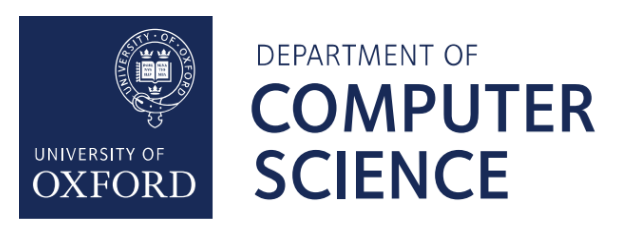

# Investigating Quantum Hardware

## Introduction:

#### This notebook investigates quantum hardware using multiple methods. It looks at heavy output and randomized circuits to calculate quantum volume. It then looks at the hardware layout of a quantum machine to see if there are methods to optimize the transpilation process, leading to a more optimal circuit that helps it pass quantum volume. Finally, it manually produces a noise model using both depolarizing and measurement errors that together with  different topologies are added to an ideal simulator to create a noisy machine. Then, quantum volume test is run on that machine. 




In [1]:

#data analytics and visualization libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import permutations
from collections.abc import Iterable

#math libraries
import numpy as np
import scipy, random
import statistics as sts
from scipy import stats
from itertools import permutations

#qiskit libraries
import qiskit
from qiskit.quantum_info import random_unitary, random_clifford
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.providers.fake_provider import FakeSantiago, FakeAthens, FakeBoeblingenV2, FakePrague, FakeLondonV2, FakeNairobiV2, FakeOslo
from qiskit.providers.fake_provider import FakeCasablancaV2
from qiskit_experiments.library import QuantumVolume
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import QuantumVolume as QuantumVolumeCircuit
from qiskit_experiments.library import QuantumVolume
from qiskit.providers.fake_provider.backends import boeblingen
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_bloch_vector, plot_distribution, plot_error_map, plot_gate_map
from qiskit import Aer
from qiskit import QuantumCircuit, execute, transpile, IBMQ
from qiskit.circuit import Parameter, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts
from qiskit.providers.aer import AerSimulator
# from qiskit.providers.ibmq.job import job_monitor
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Pauli
from qiskit.visualization import (plot_histogram, plot_distribution,
                                  plot_bloch_multivector, plot_gate_map)
from qiskit.visualization.bloch import Bloch
from qiskit.algorithms.optimizers import (
    COBYLA, # Constrained Optimization BY Linear Approximation, cf. doi:10.1007/978-94-015-8330-5_4
    SPSA,   # Simultaneous Perturbation Stochastic Approximation, cf. https://www.jhuapl.edu/SPSA/
    ADAM,   # Based on ADAptive Moment estimation, cf. arXiv:1412.6980
    #...      many more optimizers available
)
from qiskit_ibm_provider import IBMProvider
from qiskit.transpiler import CouplingMap
from qiskit.circuit.library.generalized_gates.permutation import Permutation
#noise

from qiskit.providers.aer.noise import NoiseModel, ReadoutError, depolarizing_error, pauli_error


/var/folders/h3/c5k0z82j5tn9ct9c9cpc340r0000gn/T/ipykernel_17897/3660278987.py:40: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import (


In [2]:
provider = IBMProvider()
backend = provider.get_backend("ibmq_manila")
simulator = AerSimulator.from_backend(backend)
ideal_simulator = AerSimulator()

Steps in measuring Quantum Volume:
1. Create a circuit of with num_qubits and num_unitary operations
2. Measure the circuit on an ideal simulator: EXECUTE and count the bitstring values
3. Measure the circuit in a noisy machine. Transpile it and run it on the noisy backend. Count the bitsring values
4. Check if the **probability** outputs generated by the ideal simulator are over the median outputs.
5. Quantum Volume Experiment Requires that **at least 100 circuits** are run
6. Get get more than 2/3 on the heavy output test with 97% confidence interval

$$\frac{n_h - 2 \sqrt{n_h \cdot \left(n_s - \frac{n_h}{n_c}\right)}}{n_c \cdot n_s} > \frac{2}{3}$$

In [3]:
random.seed(100)

The following functions are utility function that are repeatedy called when an quantum heavy output test is conducted.

In [233]:
def get_ideal_counts(circuit, ideal_backend, shots)->dict:
    return execute(circuit, ideal_simulator, parameter_binds=False, shots=shots).result().get_counts()

def get_ideal_counts_probabilities(circ: QuantumCircuit,
                     ideal_provider: AerSimulator,
                     shots: int)->dict:
    '''returns the dictionary of counts probabilities'''
    counts=execute(circ, ideal_provider).result().get_counts()
    probability_dict = {key: value/sum(counts.values()) for key, value in counts.items()}
    return probability_dict


def get_real_counts(circuit: QuantumCircuit, backend, shots: int, initial_layout:list[str]=None) -> dict:
    transpiled_circuit = transpile(circuit, backend, initial_layout=initial_layout, optimization_level=3)
    job = backend.run(transpiled_circuit, shots=shots, memory=True)
    return job.result().get_counts()

def get_heavy_outputs(counts: dict)->list:
    heavy_output=[]
    for key, value in counts.items():
        if value >= sts.median(counts.values()):
            heavy_output.append(key)
    return heavy_output


def heavy_output_test(nh, nc, ns)->float:
    numerator = nh - 2*np.sqrt(nh*(ns-(nh/nc)))
    denominator = nc*ns
    results = numerator/denominator
    return results

def check_ibm_volume(backend)->int:
    return backend.configuration().quantum_volume

def check_num_qubits(backend)->int:
    return backend.configuration().n_qubits

def draw_qubit_coupling_graph(initial_layout: list[list])->None:
    '''draws initial layout using NX Graph'''
    graph=nx.Graph()
    graph.add_edges_from(initial_layout)
    positions = nx.spring_layout(graph)
    nx.draw(graph, positions, with_labels=True, node_size=1000, node_color="skyblue", font_size=10, font_color="black")
    plt.show()

def plot_coupling_map(backend):
    return plot_gate_map(backend, figsize=(3,3))


def check_ibm_volume(backend)->int:
    '''Calculates IBM reported QV'''
    return backend.configuration().quantum_volume

def check_backend_configs(provider):
    for backend in list(provider.backends()):
        print(f"{backend} num qubits: {check_num_qubits(backend)}")

def set_seeds(seed=100)->None:
    random.seed(seed)
    np.random.seed(seed)


## Part 1: Calculating Quantum Volumes.

I have implemented two functions to calculate quantum volume. One of them, `ISHEAVY_qubit_by_qubit` calculates quantum volume for each qubit in the machine if the qubit passes the heavy output test described above. The algorithm `ISHEAVY`, however, calculates the quantum volume for the number of qubits given as a parameter and it fails if the test doesn't pass heavy output test.

In [ ]:
def ISHEAVY_qubit_by_qubit(device, ideal_backend, min_qubits, max_qubits, ncircuits, shots):
    '''A different version of ISHEAVY that calculates the volume for each qubit if it passes heavy output test
    '''
    quantum_volume_results = {}

    for nqubits in range(min_qubits, max_qubits + 1):
        qv_circuits = [QuantumVolumeCircuit(nqubits) for _ in range(ncircuits)]
        n_h = 0

        for circuit in qv_circuits:
            circuit.measure_all()
            
            ###COMMENT FOR YOUSELF #try both probs and counts
            ideal_counts = get_ideal_counts_probabilities(circuit, ideal_backend, shots)
            ideal_heavy_outputs = get_heavy_outputs(ideal_counts)
            real_counts = get_real_counts(circuit, device, shots)

            for bitstr, val in real_counts.items():
                if bitstr in ideal_heavy_outputs:
                    n_h += val

        results = heavy_output_test(n_h, ncircuits, shots)
        quantum_volume = np.power(2,nqubits)
        heavy_output = n_h*100 / (ncircuits * shots)

        if results>2/3:
            print(f"Quantum Volume for {nqubits} qubits: {quantum_volume}")
            print(f"Percentage Heavy Outputs: {heavy_output}")
            quantum_volume_results[nqubits] = quantum_volume
        else:
            print(f"Failed heavy output test for {nqubits} qubits")
            print(f"Percentage Heavy Outputs: {heavy_output}")
            quantum_volume_results[nqubits] = 0

    return quantum_volume_results

In [ ]:
def ISHEAVY(device, ideal_backend, nqubits: int, ncircuits: int, shots: int) -> bool:
    '''Checks if a Machine Passes Quantum Volume Test using The Algorithm in the paper
    '''
    initial_layout=None
    num_qubits=list(range(nqubits))
    qv_circuits=[QuantumVolumeCircuit(nqubits, classical_permutation=True) for _ in range(ncircuits)]
    # print(qv_circuits)

    n_h=0
    for circuit in qv_circuits:
        circuit.measure_all()
        ideal_counts=get_ideal_counts_probabilities(circuit, ideal_backend, shots)
        ideal_heavy_outputs = get_heavy_outputs(ideal_counts)
        real_counts = get_real_counts(circuit, device, shots, initial_layout)
        for bitstr, val in real_counts.items():
            if bitstr in ideal_heavy_outputs:
                n_h+=val
    results = heavy_output_test(n_h, ncircuits, shots)
    quantum_volume=np.power(2, nqubits)
    heavy_output = n_h * 100 / (ncircuits * shots)
    if results>2/3:
       print(f"passed quantum volume test for {nqubits} with quantum volume of {quantum_volume} for {device}")

    return bool(results>2/3)


I have picked a 5 Qubit Machine that is based off of the real noisy machine and that has a reported quantum volume by IBM as well. (in this case it is IBM Manila Machine)

In [7]:
check_ibm_volume(backend)

32

Checking the heavy output test for IBM Manila

In [9]:
res=ISHEAVY(simulator, ideal_simulator, 5, 250, 250)

passed quantum volume test for 5 with quantum volume of 32 for 'aer_simulator(ibmq_manila)


We can also try the same test for another machine (FAKE Santiago)

In [8]:
santiago=FakeSantiago()

In [10]:
res=ISHEAVY(santiago, ideal_simulator, 5, 150, 100)

passed quantum volume test for 5 with quantum volume of 32 for fake_santiago


In [11]:
res

True

This passes the quantum volume test for a 5 qubit machine that is the fake machine based off of IBM Santiago Machine. The Reported IBM Quantum Volume for this provider is 32 as shown below

In [12]:
check_ibm_volume(santiago)

32

This shows the same quantum volume for IBM Santiago and IBM Manilla. Both IBM test and our tests `show quantum volume of 32 for these two machines`

Now, we run the same machine on our first algorithm `ISHEAVY_qubit_by_qubit` that calculates the quantum volume for each qubit in the machine and we will compare that with the reported IBM quantum volume

In [13]:
min_qubits=2; max_qubits=check_num_qubits(santiago)
max_qubits

5

In [14]:
results = ISHEAVY_qubit_by_qubit(santiago, ideal_simulator,min_qubits, max_qubits, 100, 150)

Quantum Volume for 2 qubits: 4
Percentage Heavy Outputs: 76.82666666666667
Quantum Volume for 3 qubits: 8
Percentage Heavy Outputs: 80.08666666666667
Quantum Volume for 4 qubits: 16
Percentage Heavy Outputs: 77.4
Quantum Volume for 5 qubits: 32
Percentage Heavy Outputs: 77.68


This also shows the same quantum volume as reported by IBM

## Part 2

In this part, I refer to figure 7 of the paper: [**Optimal Quantum Circuits for General Two-Qubit Gates**](https://arxiv.org/abs/quant-ph/0308006) in which it explains that every two qubit gate can be realized, up to a global phase, by a circuit of 15 basic unitaries and 3 CNOTS.

The `RandomCircGenerator` **class** below creates a random circuit and a quantum volume based on that. If the width `number of qubits` in the circuit is odd, one of the qubits is skipped and no random unitary is applied to that qubit.

In [ ]:
class RandomCircGenerator():
    def __init__(self, device, ideal_backend, num_qubits, 
                 num_circuits, division_const, 
                 shots, flag:bool=True, 
                 initial_layout:list[str]=None):
      self.num_qubits=num_qubits
      self.division_const=division_const
      self.device=device
      self.num_circuits=num_circuits
      self.ideal_backend=ideal_backend
      self.shots=shots
      self.flag=flag
      self.initial_layout=initial_layout
      self.randomize_qubits(self.num_qubits)
    def randomize_qubits(self, num_qubits):
        control, target = random.sample(range(num_qubits), 2)
        return control, target

    def unitary_operations(self, unitaries: list = ["U", "RY", "RX", "RZ", "SXDG"]):
        unitary_op = random.choice(unitaries)
        return unitary_op


    def create_two_qubit_circuit(self, num_qubits: int = 2, num_unitaries: int = 15) -> QuantumCircuit:
        '''Creates a circuit of 15 single qubits basic operations
        and 3 alternating CNOTS to represent a SWAP
        '''
        assert num_qubits == 2
        cNot_counts=0
        cnot_positions=random.sample(range(1, num_unitaries), 3)
        qc = QuantumCircuit(num_qubits)
        control, target=self.randomize_qubits(num_qubits)
        for i in range(num_unitaries):
            qc.u(np.pi/2, 0, -np.pi/4, 0)
    #just an attempt in putting the CNOTs forming a SWAP to look like figure 7 in the second paper
            if i%5==0:
                if cNot_counts<3:
                    qc.cx(control, target)
                    cNot_counts+=1

            if i%7==0:
                if cNot_counts<3:
                    qc.cx(target, control)
                    cNot_counts+=1
        return qc



    def generate_random_circuits(self,
                                measure: bool=False)->QuantumCircuit:
        '''creates a volume based off of two qubit random circuit generate
        '''

        #set a seed and a random number generator
        rng=np.random.default_rng(1000)

        unitary_seed=rng.integers(low=0, high=1000, size=[self.num_qubits, self.num_circuits])

        qubit_list=list(range(self.num_qubits))
        qc=QuantumCircuit(self.num_qubits)
        for j in range(self.num_qubits):
            permutation=rng.permutation(list(range(self.num_qubits)))
            layers_permutations=Permutation(self.num_qubits, permutation)
            qc.compose(layers_permutations, inplace=True)
            for i in range(np.floor(self.num_qubits/self.division_const).astype(int)):
                SU_4=self.create_two_qubit_circuit()
                qc.append(SU_4, qubit_list[i*2:i*2+2])
        if(measure):
            qc.measure_all()
        return qc
    
    def ISHEAVY_custom(self, flag:bool=True):
        '''Uses the implementation of figure 7 from the paper to generate random circuits
            (15 single qubit unitaries
            and 3 CNOTs)
        '''
        quantum_volume_results = {}
        #flag
        if flag:
            ibm_results = ISHEAVY(self.device, self.ideal_backend, self.num_qubits, self.num_circuits, self.shots)
            print(f"FLAG CHECK: heavy output results for IBM is {ibm_results} for {self.num_qubits} qubits")

        for nqubits in range(1, self.num_qubits+1):
            qv_circuits = []
            for _ in range(self.num_circuits):
                qv_circuits.append(self.generate_random_circuits(False))

            n_h = 0

            for circuit in qv_circuits:
                circuit.measure_all()
                ideal_counts = get_ideal_counts(circuit, self.ideal_backend, self.shots)
                ideal_heavy_outputs = get_heavy_outputs(ideal_counts)
                real_counts = get_real_counts(circuit, self.device, self.shots)

                for bitstr, val in real_counts.items():
                    if bitstr in ideal_heavy_outputs:
                        n_h += val

            results = heavy_output_test(n_h, self.num_circuits, self.shots)
            print(results)
            quantum_volume = np.power(2, nqubits)
            heavy_output = n_h*100 / (self.num_circuits * self.shots)

            quantum_volume_results[nqubits] = quantum_volume

            if results>2/3:
                print(f"Quantum Volume for {nqubits} qubits: {quantum_volume}")
                print(f"Percentage Heavy Outputs: {heavy_output}")
            else:
                print(f"Failed heavy output test for {nqubits} qubits")
                print(f"Percentage Heavy Outputs: {heavy_output}")

            # if ibm_results and results:
            #     print("Results are the same. Both pass heavy output.")
            # elif not ibm_results and not results:
            #     print("Results are the same. Both fail heavy output.")
            # else:
            #     print("Results aren't the same.")

        return quantum_volume_results


def generate_random_circuits_unitary_qiskit(num_qubits:int,
                             division_const: int,
                             measure: bool=False)->QuantumCircuit:
    '''not a class member method but standalone function 
       that attempts to generate quantum volume but using qiskit's HAAR unitary
    '''
    qubits_list=list(range(num_qubits))
    random.shuffle(qubits_list)
    circ_width=len(qubits_list)
    qc=QuantumCircuit(circ_width)
    for j in range(len(qubits_list)):
        for i in range(np.floor(circ_width/division_const).astype(int)):
            unitary_4=random_unitary(4)
            qc.append(unitary_4, qubits_list[i*2:i*2+2])
    if(measure):
        qc.measure_all()
    return qc

In [184]:
santiago = FakeSantiago()

In [185]:
random_obj=RandomCircGenerator(device=santiago, ideal_backend=ideal_simulator, num_qubits=5, num_circuits=150, division_const=2, shots=500)

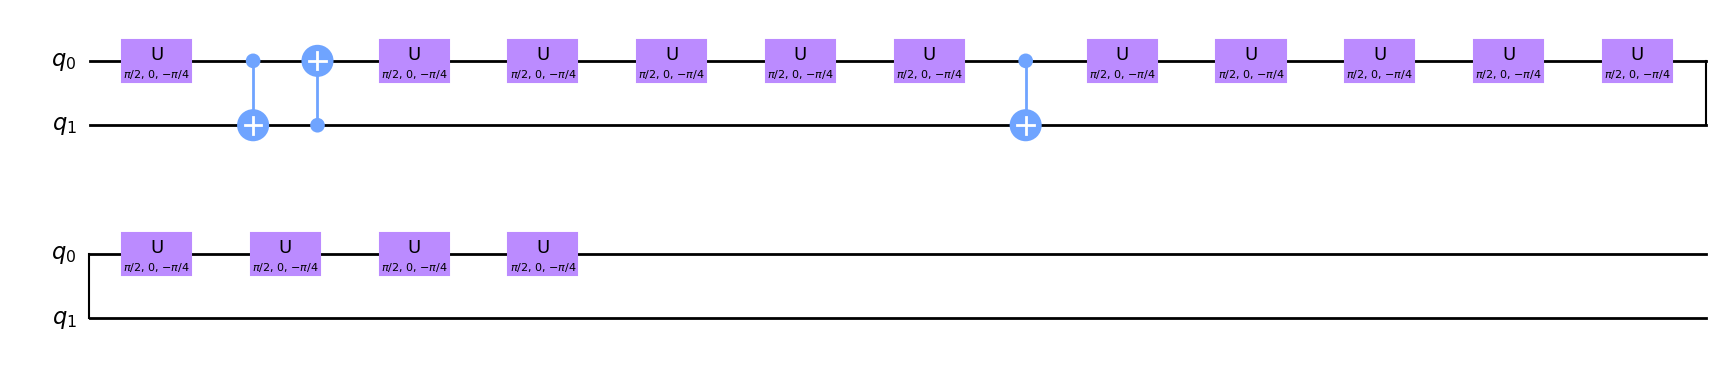

In [24]:
random_obj.create_two_qubit_circuit().draw("mpl")

As we can see it looks similar to the circuit in figure 7 of the paper. It is composed of 7 single qubit unitaries and 3 alternating CNOTS forming a SWAP Pattern.

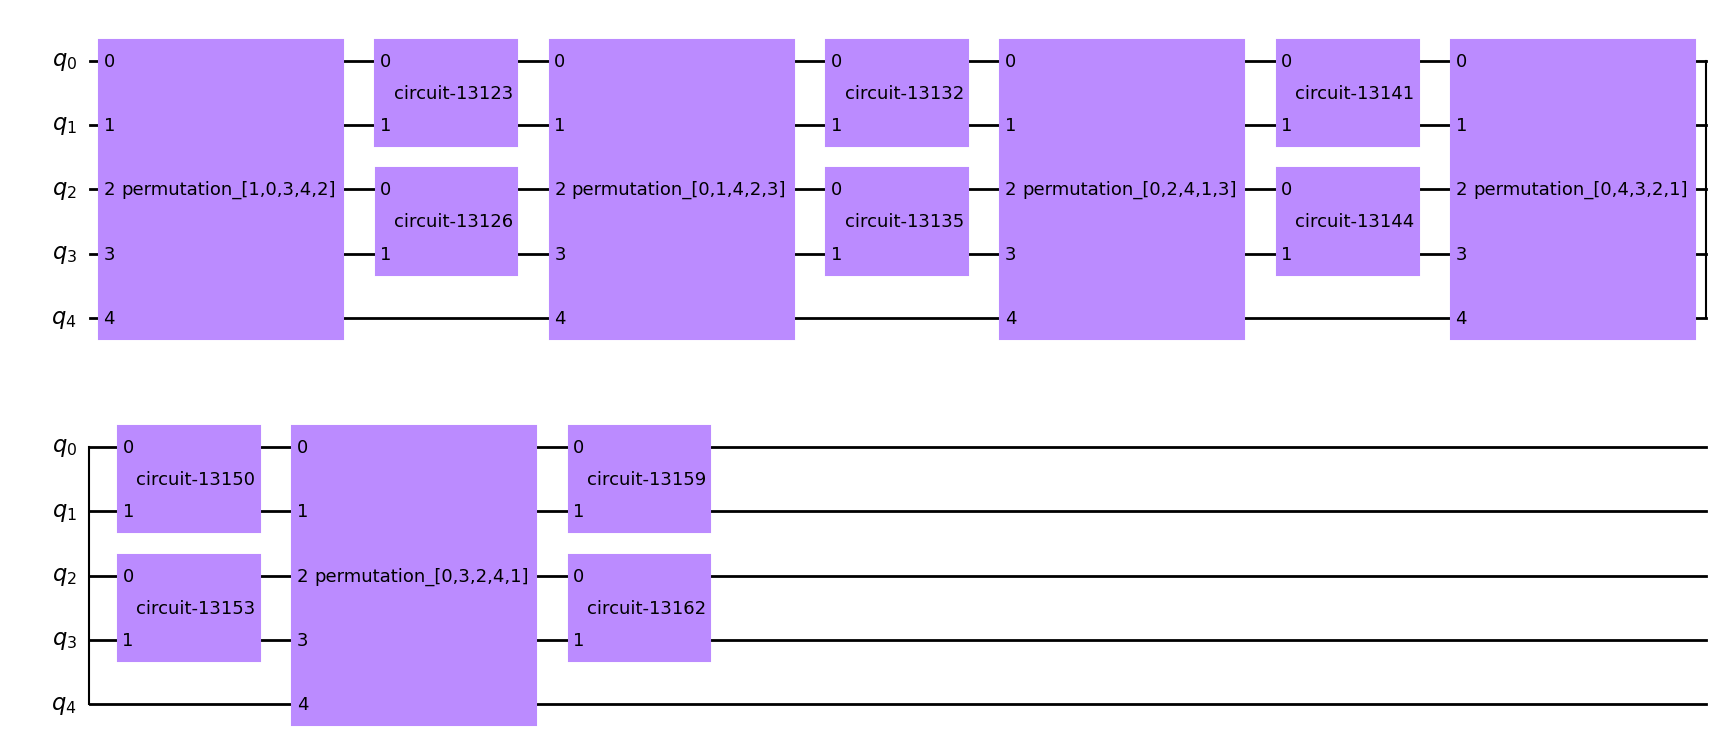

In [25]:
random_obj.generate_random_circuits(False).draw("mpl")

Now to check similarities, I will also call IBM QuantumVolume to create a circuit with 5 qubits and draw it.

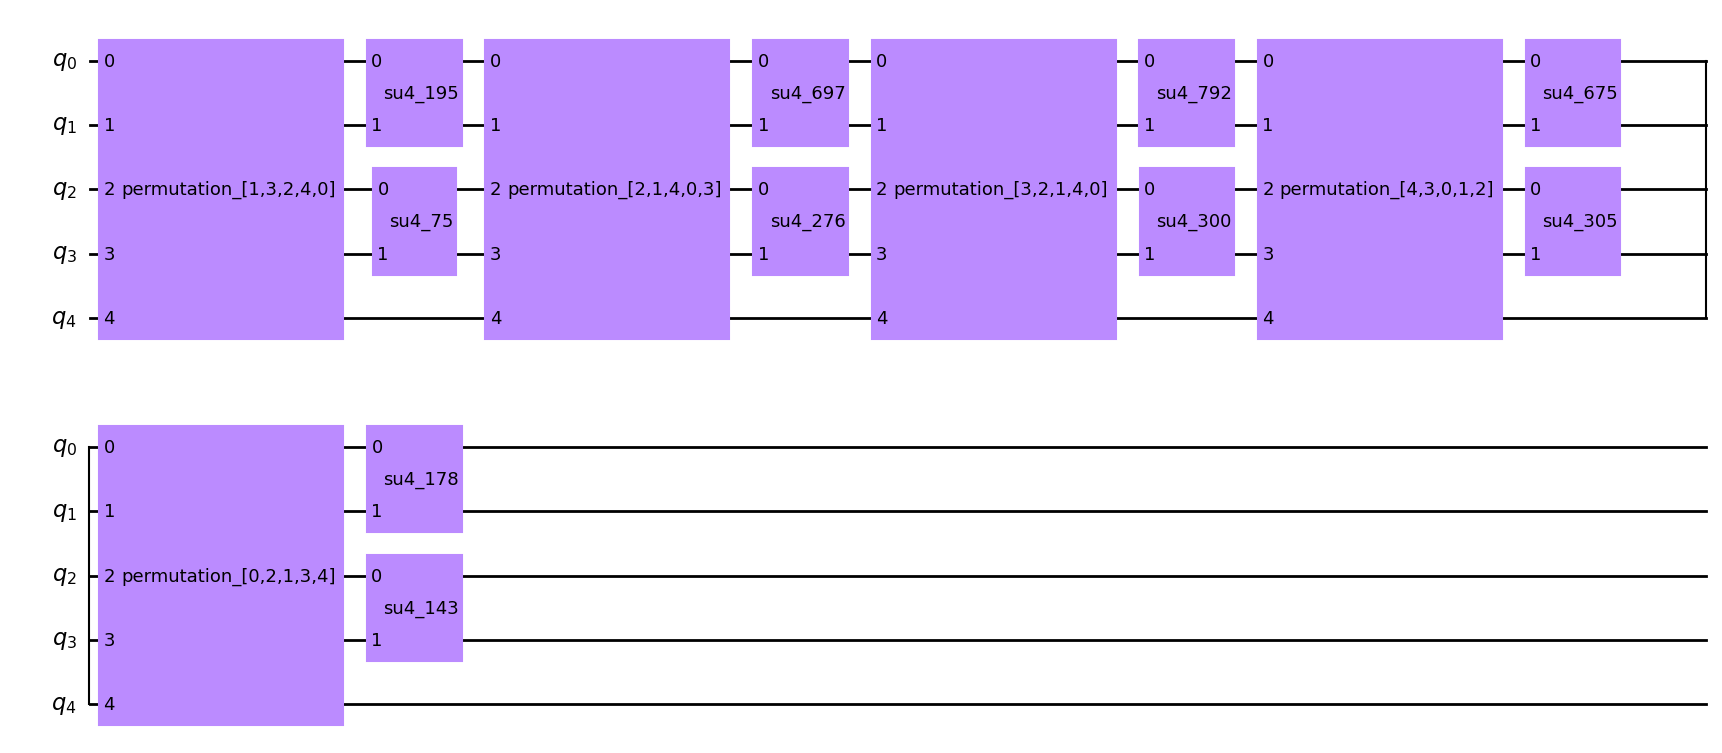

In [121]:
qv=QuantumVolumeCircuit(5,5, classical_permutation=False)
qv.decompose().draw("mpl")

The random circuit generator creates a pretty similar circuit to IBM Quantum Volume. 

Next, I will run the Quantum Volume test for IBM fake Santiago. This utilizes `ISHEAVY_custom` method which in turn calls the class methods such as `create_two_qubit_circuit` and `generate_random_circuits`. 

In [122]:
results=random_obj.ISHEAVY_custom()

passed quantum volume test for 5 with quantum volume of 32 for fake_santiago
FLAG CHECK: heavy output results for IBM is True for 5 qubits
0.6821945901984452
Quantum Volume for 1 qubits: 2
Percentage Heavy Outputs: 75.26533333333333
0.6825306049247427
Quantum Volume for 2 qubits: 4
Percentage Heavy Outputs: 75.296
0.6768102396697402
Quantum Volume for 3 qubits: 8
Percentage Heavy Outputs: 74.77333333333333
0.6844160979164977
Quantum Volume for 4 qubits: 16
Percentage Heavy Outputs: 75.468
0.6811284249927756
Quantum Volume for 5 qubits: 32
Percentage Heavy Outputs: 75.168


As we can see this method passes quantum volume test as well for 5 qubits and based on the flag we can see that the method from question 1 using IBM's Quantum Volume also passes the Test for 5 qubits.

## Part 3

In this part I am investigating different permutations of initial_layout on a 7 qubit machine to see if it passes the quantum volume test and then output the estimated heavy output probabilities. 

By calling `check_backend_configs()` we will have an idea of what 7 qubit noisy machines we have access to. 

In [93]:
random.seed(100)

In [69]:
check_backend_configs(IBMProvider())

<IBMBackend('ibm_perth')> num qubits: 7
<IBMBackend('ibmq_qasm_simulator')> num qubits: 32
<IBMBackend('ibmq_lima')> num qubits: 5
<IBMBackend('simulator_mps')> num qubits: 100
<IBMBackend('simulator_statevector')> num qubits: 32
<IBMBackend('ibmq_manila')> num qubits: 5
<IBMBackend('ibm_nairobi')> num qubits: 7
<IBMBackend('ibmq_quito')> num qubits: 5
<IBMBackend('ibmq_belem')> num qubits: 5
<IBMBackend('simulator_extended_stabilizer')> num qubits: 63
<IBMBackend('simulator_stabilizer')> num qubits: 5000
<IBMBackend('ibm_lagos')> num qubits: 7
<IBMBackend('ibmq_jakarta')> num qubits: 7


We can pick any 7 qubit noisy machine and then create a simulator off of that. I will pick `IBM Jakarta` for that purpose. We could have picked `IBM Perth` and `IBM Nairobi` too but these two machines were occasionally not available as I was running experiments. `IBM Jakarta` machine was consistently reliable.  

In [11]:
jakarta=provider.get_backend('ibmq_jakarta')
jakarta_simulator=AerSimulator.from_backend(jakarta)
ideal_simulator=AerSimulator()

We can now check the reported IBM quantum volume for this machine.

In [71]:
print(f"the IBM volume for {jakarta} is {check_ibm_volume(jakarta)}")

the IBM volume for <IBMBackend('ibmq_jakarta')> is 16


As the reported IBM Quantum Volume for this particular machine `IBM Jakarta` is 16, I will keep experiments mostly to at most 4 qubits using a different combination of 3 or 4 qubits by having a look at the error map and the coupling map of the hardware. But, lets first run a test using algorithm in question 1 `ISHEAVY_qubit_by_qubit` and run it for 4 qubits on the simulator to see if we get the same quantum volume results as reported by IBM. I will test this with minimum of 2 qubits and up to 4 qubits. This utiizes the QuantumVolume class from qiskit

In [94]:
quantum_volume_jakarta=ISHEAVY_qubit_by_qubit(jakarta_simulator, ideal_simulator, 2, 4, 200, 200)

Quantum Volume for 2 qubits: 4
Percentage Heavy Outputs: 76.535
Quantum Volume for 3 qubits: 8
Percentage Heavy Outputs: 76.855
Quantum Volume for 4 qubits: 16
Percentage Heavy Outputs: 73.8675


It calculates a quantum volume of 16, similar to IBM which reports a heavy ouput test for 4 qubits. Interestingly, the percentage of heavy output stays high and all qubits, decreasing as the number of qubits increase. It shows a 70%+ heavy output for 4 qubits.

<!-- This consistently fails heavy output test as it returns results just shy of 2/3. Most results are around 60% heavy. Despite the percentage heavy.  -->

Next, we can customize `ISHEAVY` again to take advantage of qiskit's random_unitary function instead of our random circuit generator using 3 CNOTS and 15 unitaries. As we will also be providing initial_layout both to `ISHEAVY_qubit_by_qubit_haar` and to methods introduced later in this section, we will need to make changes to `get_real_counts` as well that accepts initial_layout as a param. I could have changed `get_real_counts` but a lot of other codes use it already so decided to keep it simple and create another function. 

In [216]:
def get_real_counts_initial_layout(circuit: QuantumCircuit, backend, shots: int, initial_layout:list[int]) -> dict:
    '''transpiles circuit using a more advanced optimizarion level
       uses a custom initial layout
       runs the transpiled circuit and returns the dictionary counts
    '''
    transpiled_circuit = transpile(circuit, backend, optimization_level=3, initial_layout=initial_layout)
    job = backend.run(transpiled_circuit, shots=shots, memory=True)
    return job.result().get_counts()

In [ ]:
def ISHEAVY_qubit_by_qubit_haar(device, 
                                ideal_backend, 
                                min_qubits, 
                                max_qubits, 
                                ncircuits, 
                                shots,
                                initial_layout=None):
    '''A different version of ISHEAVY that calculates the volume for each qubit if it passes heavy output test
    '''
    quantum_volume_results = {}

    for nqubits in range(min_qubits, max_qubits + 1):
        #calls the implementation of quantum volume using random_unitary HAAR4 from qiskit
        qv_circuits = [generate_random_circuits_unitary_qiskit(nqubits,2) for _ in range(ncircuits)]
        n_h = 0

        for circuit in qv_circuits:
            circuit.measure_all()
            ideal_counts = get_ideal_counts(circuit, ideal_backend, shots)
            ideal_heavy_outputs = get_heavy_outputs(ideal_counts)
            if initial_layout:
                real_counts=get_real_counts_initial_layout(circuit, device, shots, initial_layout)
            else:
                real_counts=get_real_counts(circuit, device, shots)

            for bitstr, val in real_counts.items():
                if bitstr in ideal_heavy_outputs:
                    n_h += val

        results = heavy_output_test(n_h, ncircuits, shots)
        quantum_volume = np.power(2,nqubits)
        heavy_output = n_h * 100 / (ncircuits * shots)

        if results>2/3:
            print(f"Quantum Volume for {nqubits} qubits: {quantum_volume}")
            print(f"Percentage Heavy Outputs: {heavy_output}")
            quantum_volume_results[nqubits] = quantum_volume
        else:
            print(f"Failed heavy output test for {nqubits} qubits")
            print(f"Percentage Heavy Outputs: {heavy_output}")
            quantum_volume_results[nqubits] = 0

    return quantum_volume_results

In [210]:
random.seed(100)
ISHEAVY_qubit_by_qubit_haar(jakarta_simulator, ideal_simulator, 2, 4, 200, 200)

Quantum Volume for 2 qubits: 4
Percentage Heavy Outputs: 74.61
Quantum Volume for 3 qubits: 8
Percentage Heavy Outputs: 74.11
Quantum Volume for 4 qubits: 16
Percentage Heavy Outputs: 80.53


{2: 4, 3: 8, 4: 16}

This also passes quantum volume test. 

In order to be able to have a better compliation process, a number of factors are important to take into account:

1. Optimization Level. This can be 0-3. I have explained my reasoning why we should use one over the other especially on benefits of optimization_level 3, later on in this section.
2. Initial Layout. A good initial layout can help a transpiler avoiding complex and expensive swap operations. To have a good initial layput, it is important to map logical qubits to:

        a. Physical qubits that are most connected in the coupling map. This helps prevent expensive and noisy CNOT operations to SWAP qubits.
        b. Physical qubits that have lower CNOT errors.
        c. Physical qubits that have lower readout errors.
        d. An initial layout that avoids successive alternating CNOTs (SWAPS = 3 alternating CNOTS)
Before we start, lets have a look at the Error Map and the Coupling Map of IBM Jakarta

But first lets change `ISHEAVY_qubit_by_qubit` function to simply take advantage of initial layout in transpile call and to decouple transpile method from `get_real_counts` function. The functions below calculate heavy output and quantum volume while acceping `initial_layout` as an argument.

In [ ]:

def ISHEAVY_qubit_by_qubit_initial_layout(device, ideal_backend, max_qubits, ncircuits, shots, initial_layout:list[int]):
    '''A different version of ISHEAVY that calculates the volume for each qubit if it passes heavy output test
    '''

    qv_circuits = [QuantumVolumeCircuit(max_qubits) for _ in range(ncircuits)]
    n_h = 0

    for circuit in qv_circuits:
        circuit.measure_all()
        ideal_counts = get_ideal_counts(circuit, ideal_backend, shots)
        ideal_heavy_outputs = get_heavy_outputs(ideal_counts)
        real_counts=get_real_counts_initial_layout(circuit, device, shots, initial_layout)
        for bitstr, val in real_counts.items():
            if bitstr in ideal_heavy_outputs:
                n_h += val

    results = heavy_output_test(n_h, ncircuits, shots)
    print(results)
    quantum_volume = np.power(2,max_qubits)
    heavy_output = n_h * 100 / (ncircuits * shots)

    if results>2/3:
        print(f"Quantum Volume for {max_qubits} qubits: {quantum_volume}")
        print(f"Percentage Heavy Outputs: {heavy_output}")
    else:
        print(f"Failed heavy output test for {max_qubits} qubits")
        print(f"Percentage Heavy Outputs: {heavy_output}")

    return results



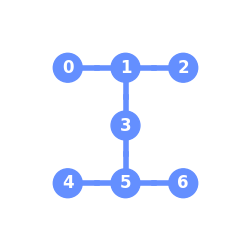

In [133]:
plot_coupling_map(jakarta)

We can see that qubits 1 and 5 are the most connected. Qubits 0 and 2, 4 and 6 are diconnected. But lets have a look at the error map to find out which qubits show lower measurement and CNOT errors (useful for SWAP operations)

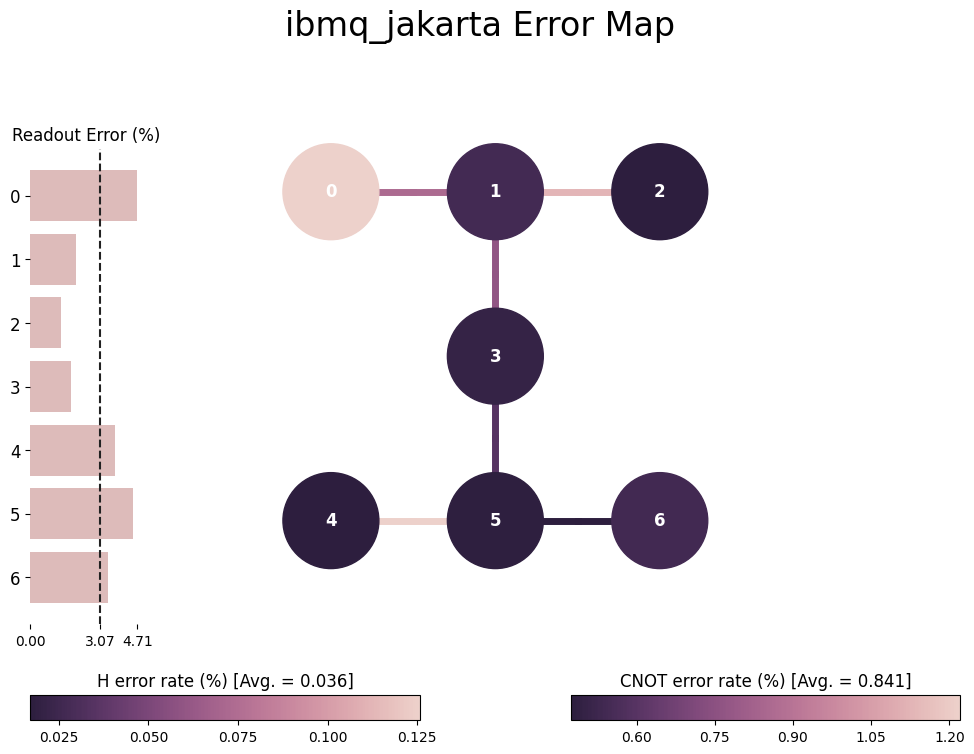

In [127]:
plot_error_map(jakarta)

Next, I would like to use three qubits, mainly qubits 1,2,3 because of the following reasons:

1. qubits 1, 2 and 3 are connected (2 and 3 through 1). 

2. qubits 1,2,3 have very low readout errors. 

3. qubit 1 has low CNOT error. It is particularly useful since qubit 1 connects qubits 2 and 3. Moreover, qubits 2 and 3 have very low CNNOT errors, in case SWAP is needed to perform two qubit operations on qubits 2 and 3.

4. Reported IBM Volume for this device is 16 so I won't be trying any more combinations than 4 qubits maximum.

So, will use such logical to physical mapping:

In [ ]:
# this logical to physical mapping [1,2,3] physical
#-------------------------logical  [0,1,2]

# logical 0 is placed at physical 1; logical 1 is placed at physical 2, logical 2 at physical 3

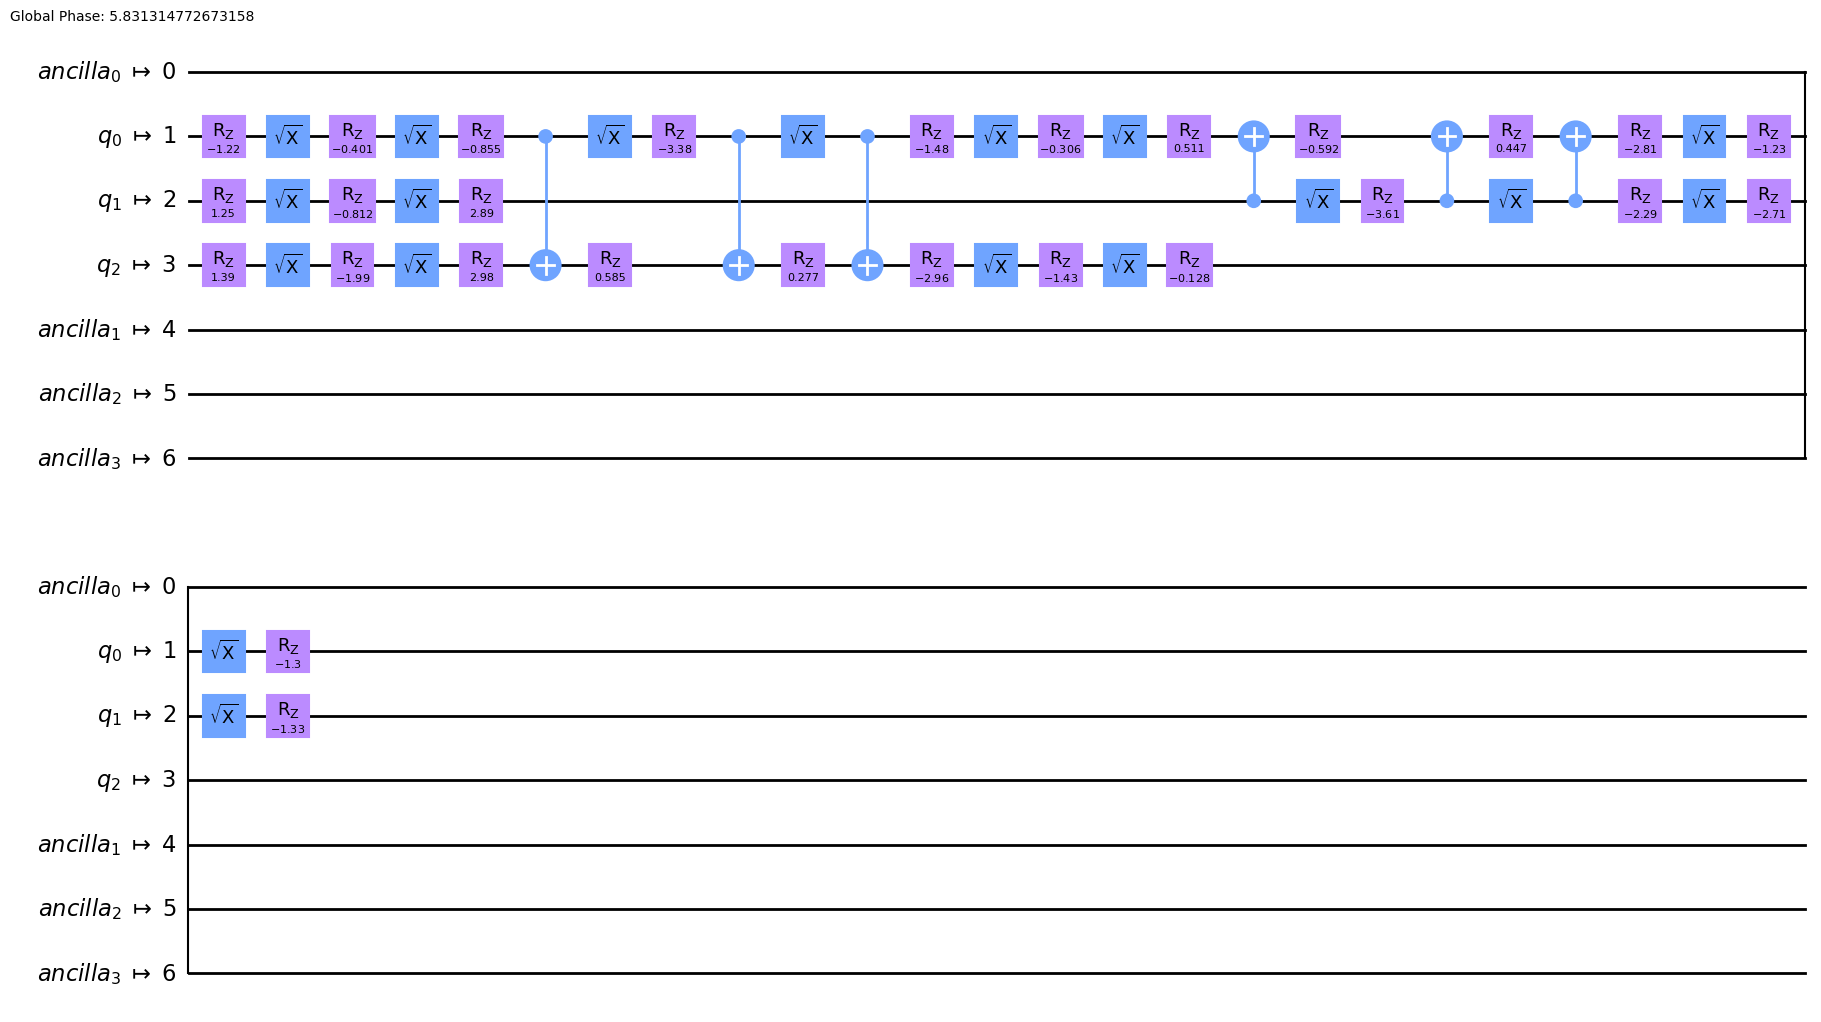

In [128]:
initial_layout=[1,2,3]

quantum_volume=QuantumVolumeCircuit(num_qubits=3,depth=3)
quantum_volume.draw("mpl")

random.seed(100)
transpiled_circ_init=transpile(quantum_volume, jakarta, initial_layout=initial_layout, optimization_level=3)
transpiled_circ_init.draw("mpl")

In [134]:
ISHEAVY_qubit_by_qubit_initial_layout(jakarta_simulator, ideal_simulator,3,250,1000,initial_layout)

0.7147668572477509
Quantum Volume for 3 qubits: 8
Percentage Heavy Outputs: 76.8148


0.7147668572477509

In [213]:
initial_layout=[1,2,3]
#min and max qubits should be the same because they should equal initial layout
ISHEAVY_qubit_by_qubit_haar(jakarta_simulator, ideal_simulator, 3, 3, 200, 200, initial_layout)

Quantum Volume for 3 qubits: 8
Percentage Heavy Outputs: 75.635


{3: 8}

Both pass heavy output test for 3 qubits. The circuit looks quite optimized qubits 0, 4, 5, and 6 aren't used in this circuit since they have high readout errors and qubit 0 has high CNOT errors. Also, we use qubits 1 and 3 that are well connected qubits. 

Logical 0 is mapped to physical 1 and logical 1 to physical 2 and logical 2 to physical 3. The circuit doesn't show any SWAPs. But lets have a look at the circuit's depth and also decompose the circuit to see if we have any SWAPS.

In [137]:
random.seed(100)
print(f"the depth of the new circuit with initial layout {initial_layout} is: {transpiled_circ_init.depth()}")

the depth of the new circuit with initial layout [1, 2, 3] is: 27


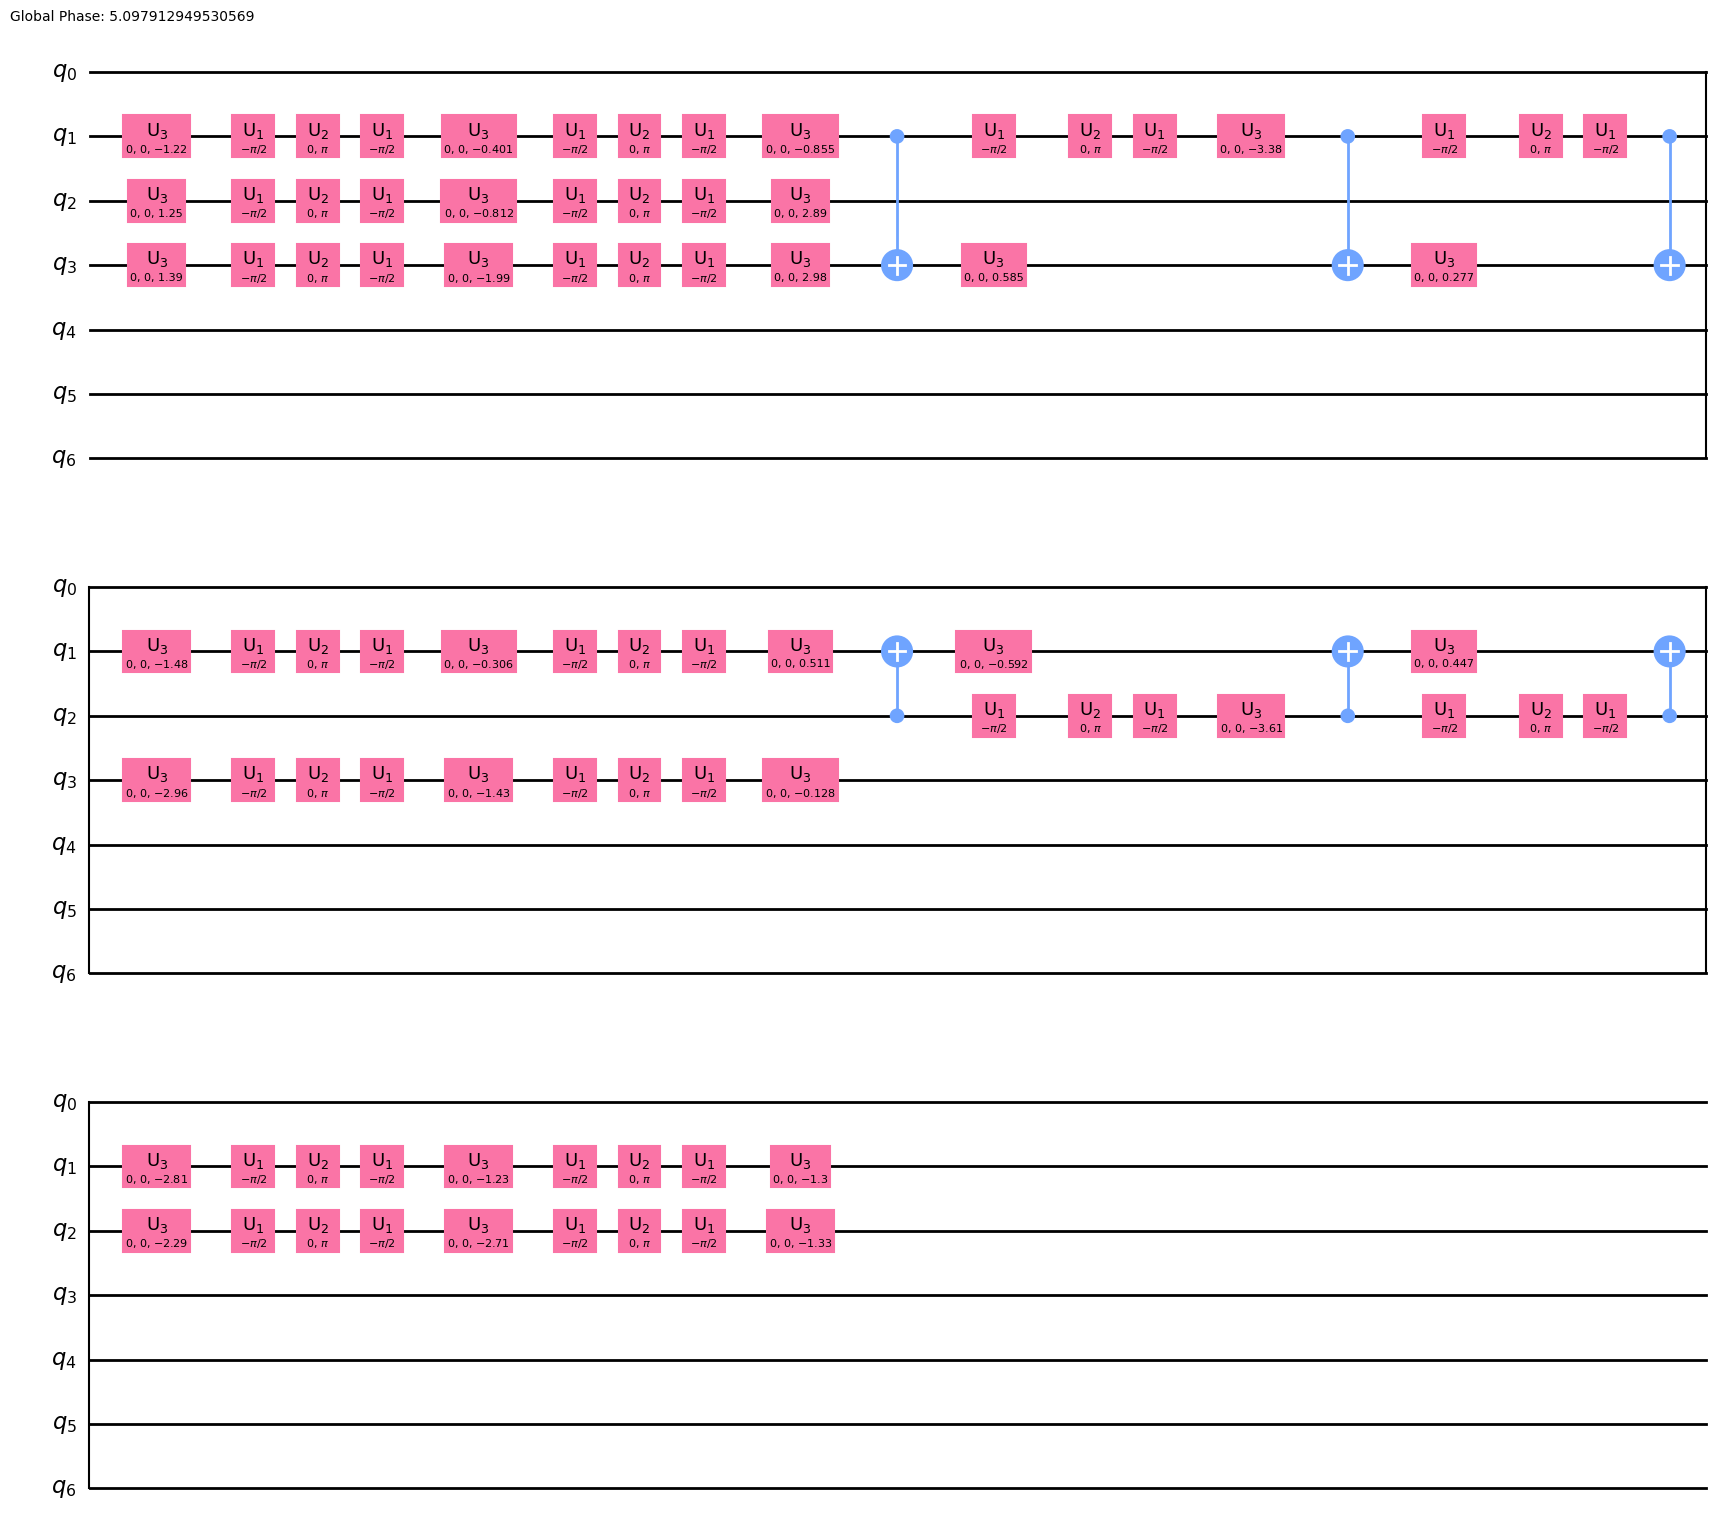

In [138]:
transpiled_circ_init.decompose().decompose().draw("mpl")

As expected, no CNOTs required. However, three qubits for a 7 qubit machine isn't an ideal configuration. We can perhaps get inspired by the reported IBM quantum volume of 16 and try 4 qubits on different initial layout configurations, judging based on the error map. 

So, we can use 4 qubits physical 1,2,3,4 that have low readout error, low CNOT error and with qubits 1 and 3 quite connected to the rest. We could have used qubit 5 as well due to its low CNOT error and high connectivity but it has the highest read-out error and this could impact our quantum volume calculation by introducing noise when bitstrings are read. We have aleady used qubits 1, 2, 3 in our previous experiment and we are now just adding qubit 4.

We are mapping logical 0 1 2 3 to physical 1 2 3 4.

In [139]:
initial_layout=[1,2,3,4]
#.       logic=[0,1,2,3,4,5,6] mapping
# so logical --> physical
      # 0             1
      # 1             2
      # 2             3
      # 3             4

Now checking the quantum volume for this machine again `without` providing initial layout but using 4 qubits because the reported IBM volume for this machine is 2^4 (16)

In [142]:
random.seed(100)
ISHEAVY_qubit_by_qubit(jakarta_simulator, ideal_simulator, 2, 4, 250, 250)

Quantum Volume for 2 qubits: 4
Percentage Heavy Outputs: 77.1584
Quantum Volume for 3 qubits: 8
Percentage Heavy Outputs: 77.1152
Quantum Volume for 4 qubits: 16
Percentage Heavy Outputs: 73.1952


{2: 4, 3: 8, 4: 16}

In [145]:
initial_layout=[1,2,3,4]
random.seed(100)
#increasing the number of shots, while keeping the number of circuits the same
ISHEAVY_qubit_by_qubit_initial_layout(jakarta_simulator, ideal_simulator,4,250,400,initial_layout)

0.6735340883082437
Quantum Volume for 4 qubits: 16
Percentage Heavy Outputs: 72.971


0.6735340883082437

This initial layout, interestingly, just passes quantum volume test for 4 qubits. I had run the same experiment with fewer shots than 400 shots and it just failed quantum volume test. Interesting.

In [214]:
initial_layout=[1,2,3,4]
ISHEAVY_qubit_by_qubit_haar(jakarta_simulator, ideal_simulator, 4, 4, 200, 200, initial_layout)

Quantum Volume for 4 qubits: 16
Percentage Heavy Outputs: 81.43


{4: 16}

This also passes quantum volume test. 

Out of interest, I would like to see how the transpiler transpiles a quantum volume on the backend without providing an initial layout. This can help us see which qubits are used and what swap operations are performed.

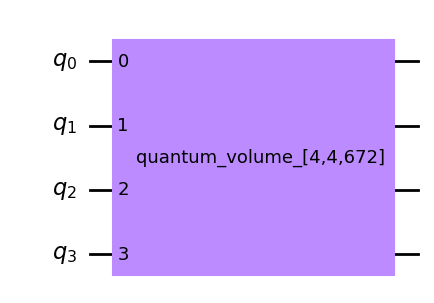

In [146]:
quantum_volume=QuantumVolumeCircuit(num_qubits=4,depth=4)
quantum_volume.draw("mpl")

In [147]:
jakarta

<IBMBackend('ibmq_jakarta')>

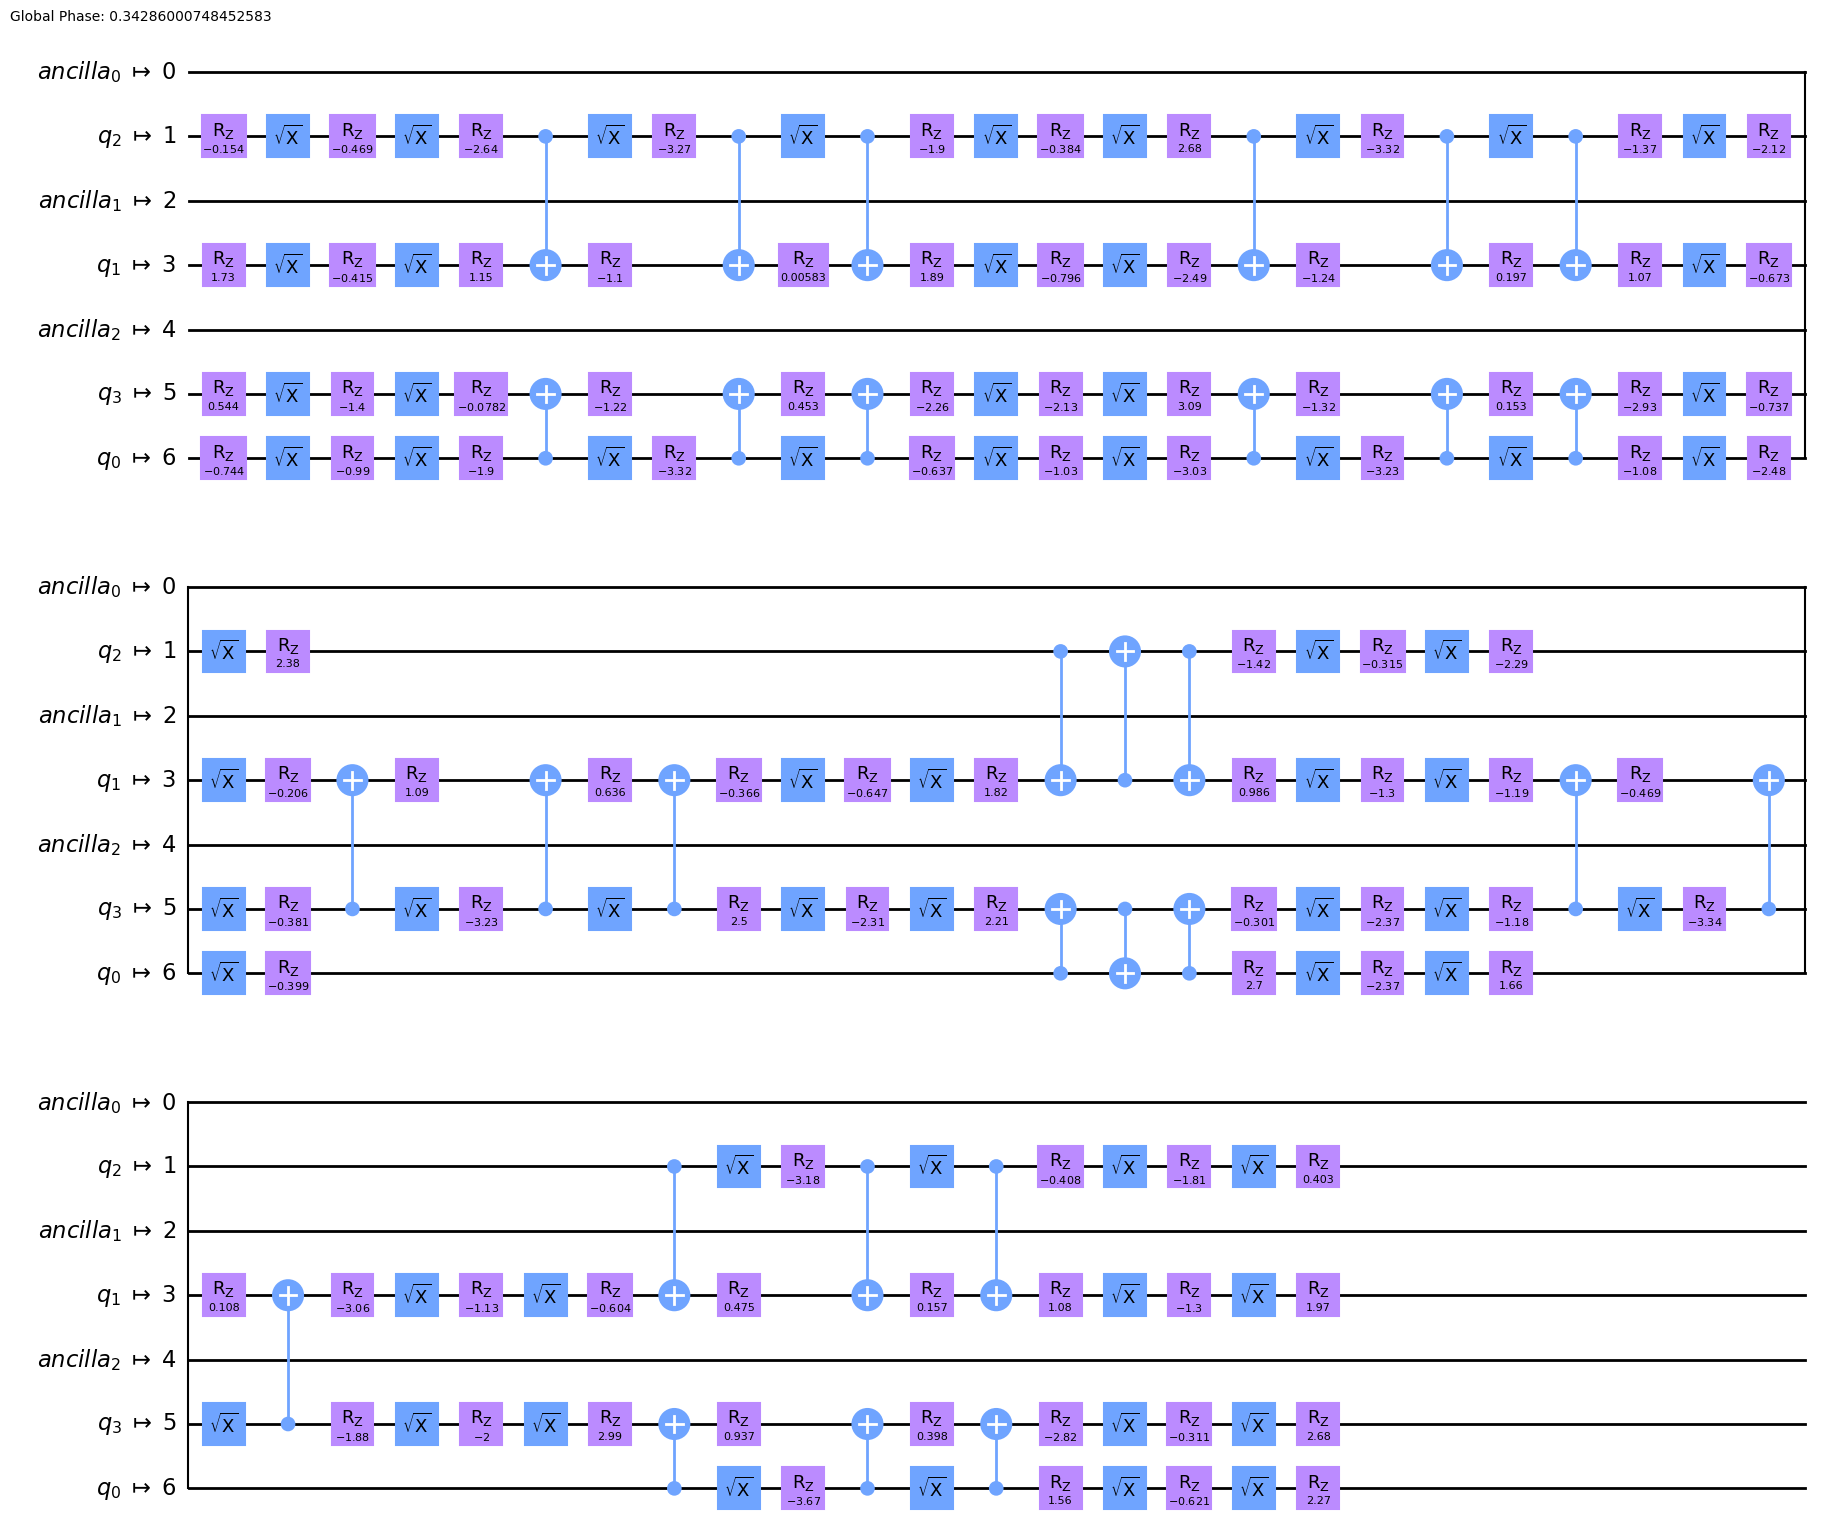

In [149]:
random.seed(100)
transpiled_volume=transpile(quantum_volume, jakarta)
transpiled_volume.draw("mpl")

It is interesting that qubits 0, 2 and 4 are not used at all. We may want to see the depth of the circuit with and without initial layout and then compare it to the depth of the circuit and the type of circuit generated and the qubits used with providing a logical physical mapping of our choosing.

In [150]:
print(f"the depth of the circuit is: {transpiled_volume.depth()}")

the depth of the circuit is: 68


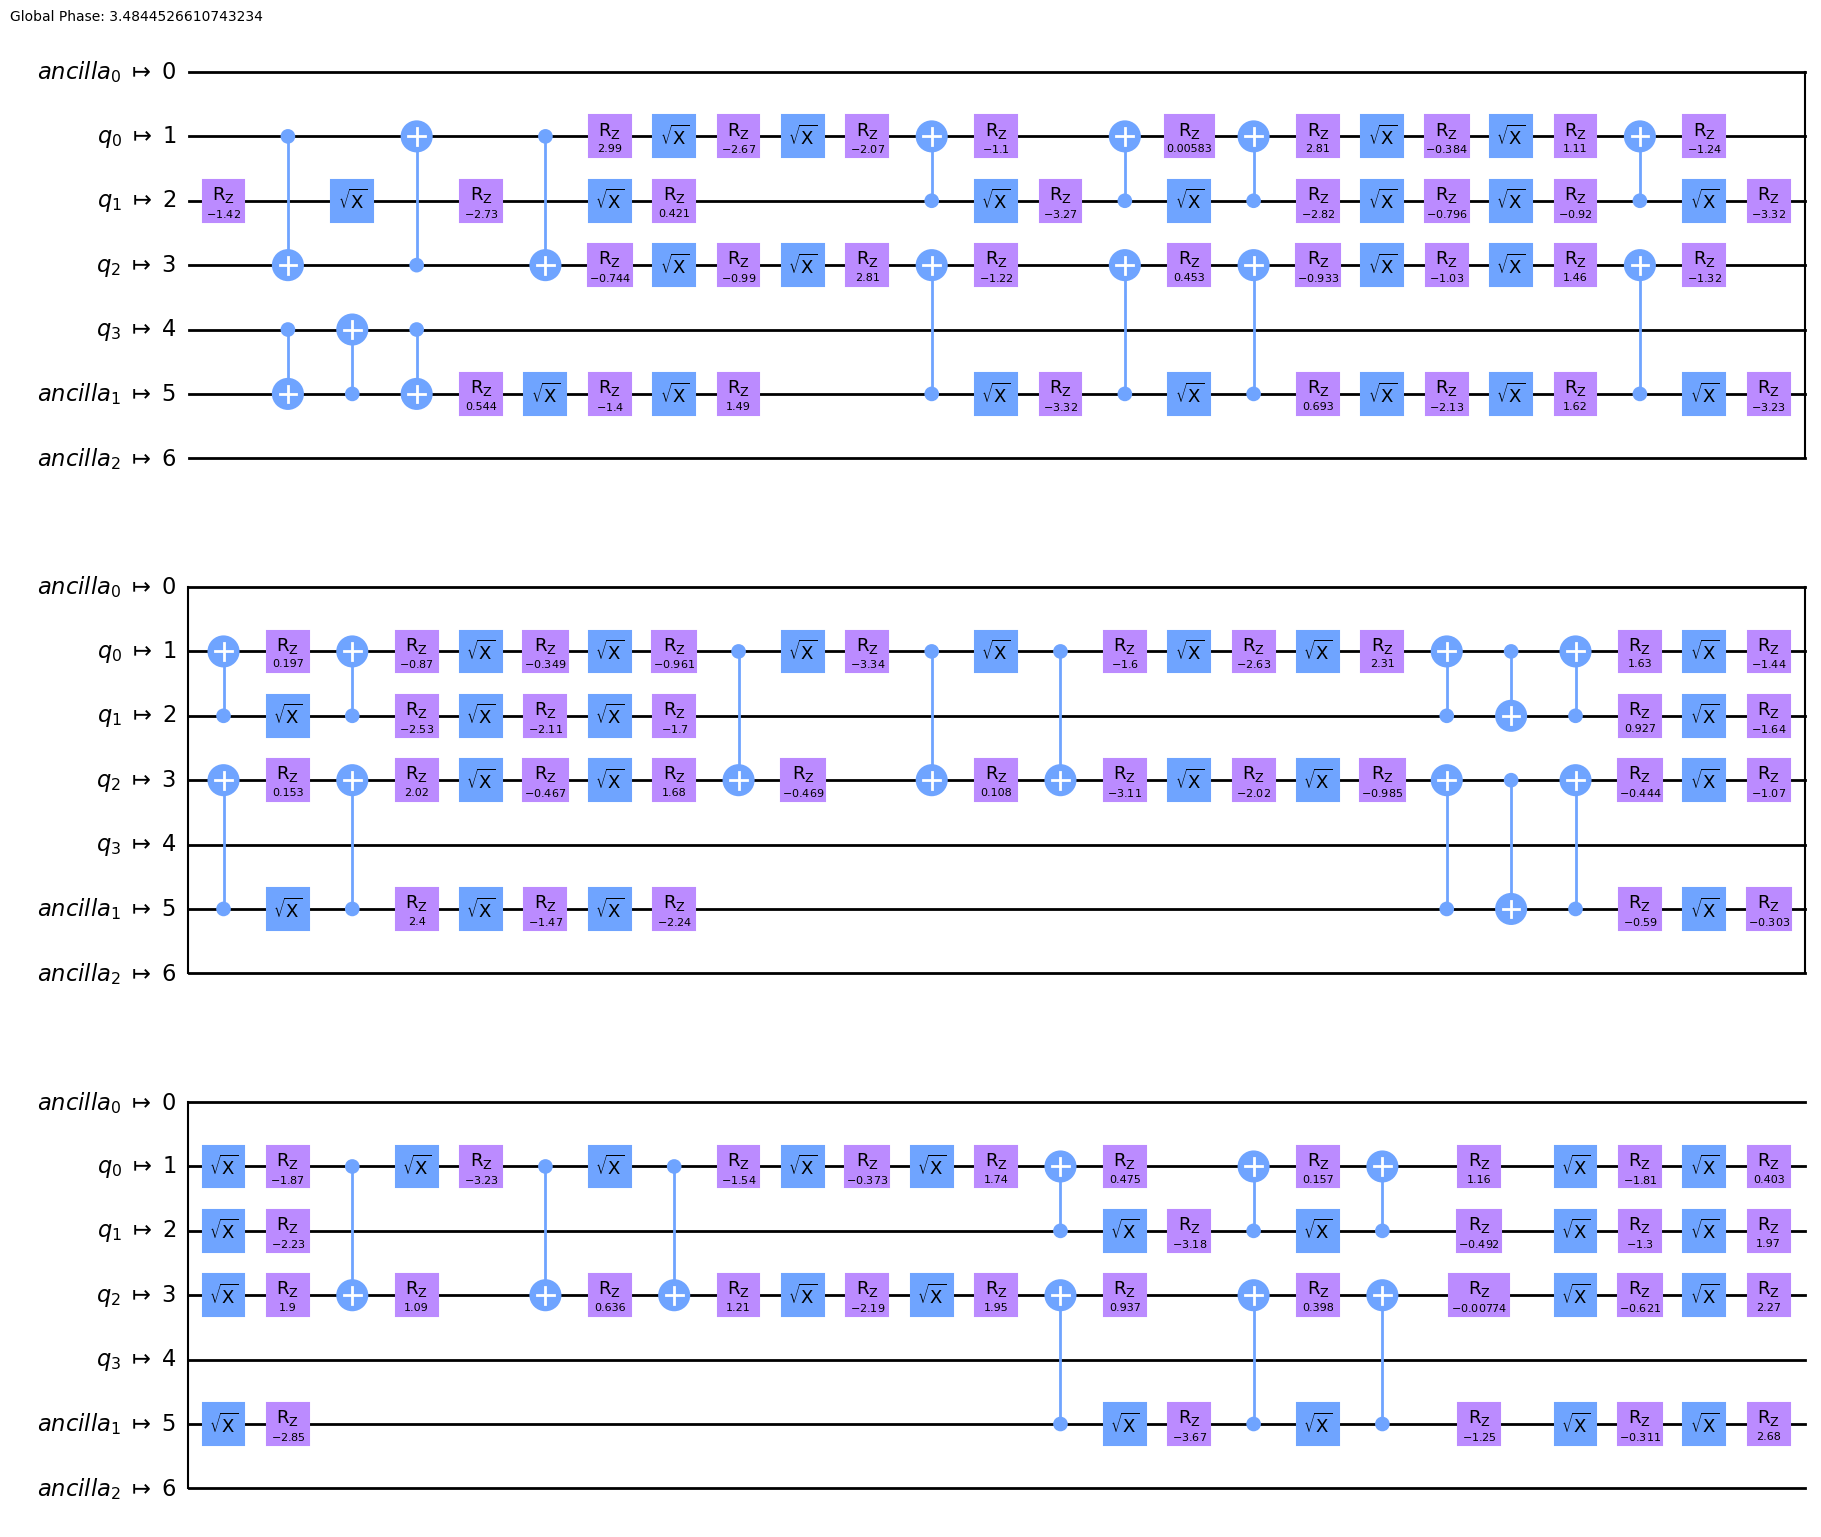

In [155]:
initial_layout=[1,2,3,4]
random.seed(100)
transpiled_circ_init=transpile(quantum_volume, jakarta, initial_layout=initial_layout)
transpiled_circ_init.draw("mpl")

Interestingly we can see that the compiler performs the following swaps:

    in the first depth it swaps qubits 1 and 3 and 4 and 5
    in the second depth it swaps qubits 1 and 2 and 3 and 5
  
Also qubits 5 is used as an ancilla qubit to help with swap operations.

Also, according to the error map, qubit 5 is the qubit with highest readout error. So, this circuit isn't optimal given such intial layout.

In [156]:
print(f"the depth of the new circuit with initial layout {initial_layout} is: {transpiled_circ_init.depth()}")

the depth of the new circuit with initial layout [1, 2, 3, 4] is: 71


Now we will try a different initial layout

In [157]:
#logical to physical mapping [0,2,1,3] physical
#-------------------logical  [0,1,2,3]

# logical 0 is placed at physical 0; logical 1 is placed at physical 2, logical 2 at physical 1 and logical 3 at physical 3


In [159]:
initial_layout=[0,2,1,3]
ISHEAVY_qubit_by_qubit_initial_layout(jakarta_simulator, ideal_simulator,4,250,400,initial_layout)

0.6677115756596737
Quantum Volume for 4 qubits: 16
Percentage Heavy Outputs: 72.424


0.6677115756596737

Now, we will test heavy output using quantum volumes created using qiskit's random_unitary not qiskit's QuantumVolume class. 

In [215]:
initial_layout=[0,2,1,3]
ISHEAVY_qubit_by_qubit_haar(jakarta_simulator, ideal_simulator, 4, 4, 200, 200, initial_layout)

Quantum Volume for 4 qubits: 16
Percentage Heavy Outputs: 80.59


{4: 16}

We can now draw the compiled circuit given this initial layout and see the depth of the circuit, the qubits used and the number of SWAPS. The fact that qubits 4 and 6 aren't well connected and qubit 5 has a very high readout error and it is in between qubits 3 and 4. Also, that qubit 6 has high readout error, compiler not using these qubits (4,5,6) as ancilla qubits may lead to a more optimizated circuit. This can be seen from the circuit generated below.

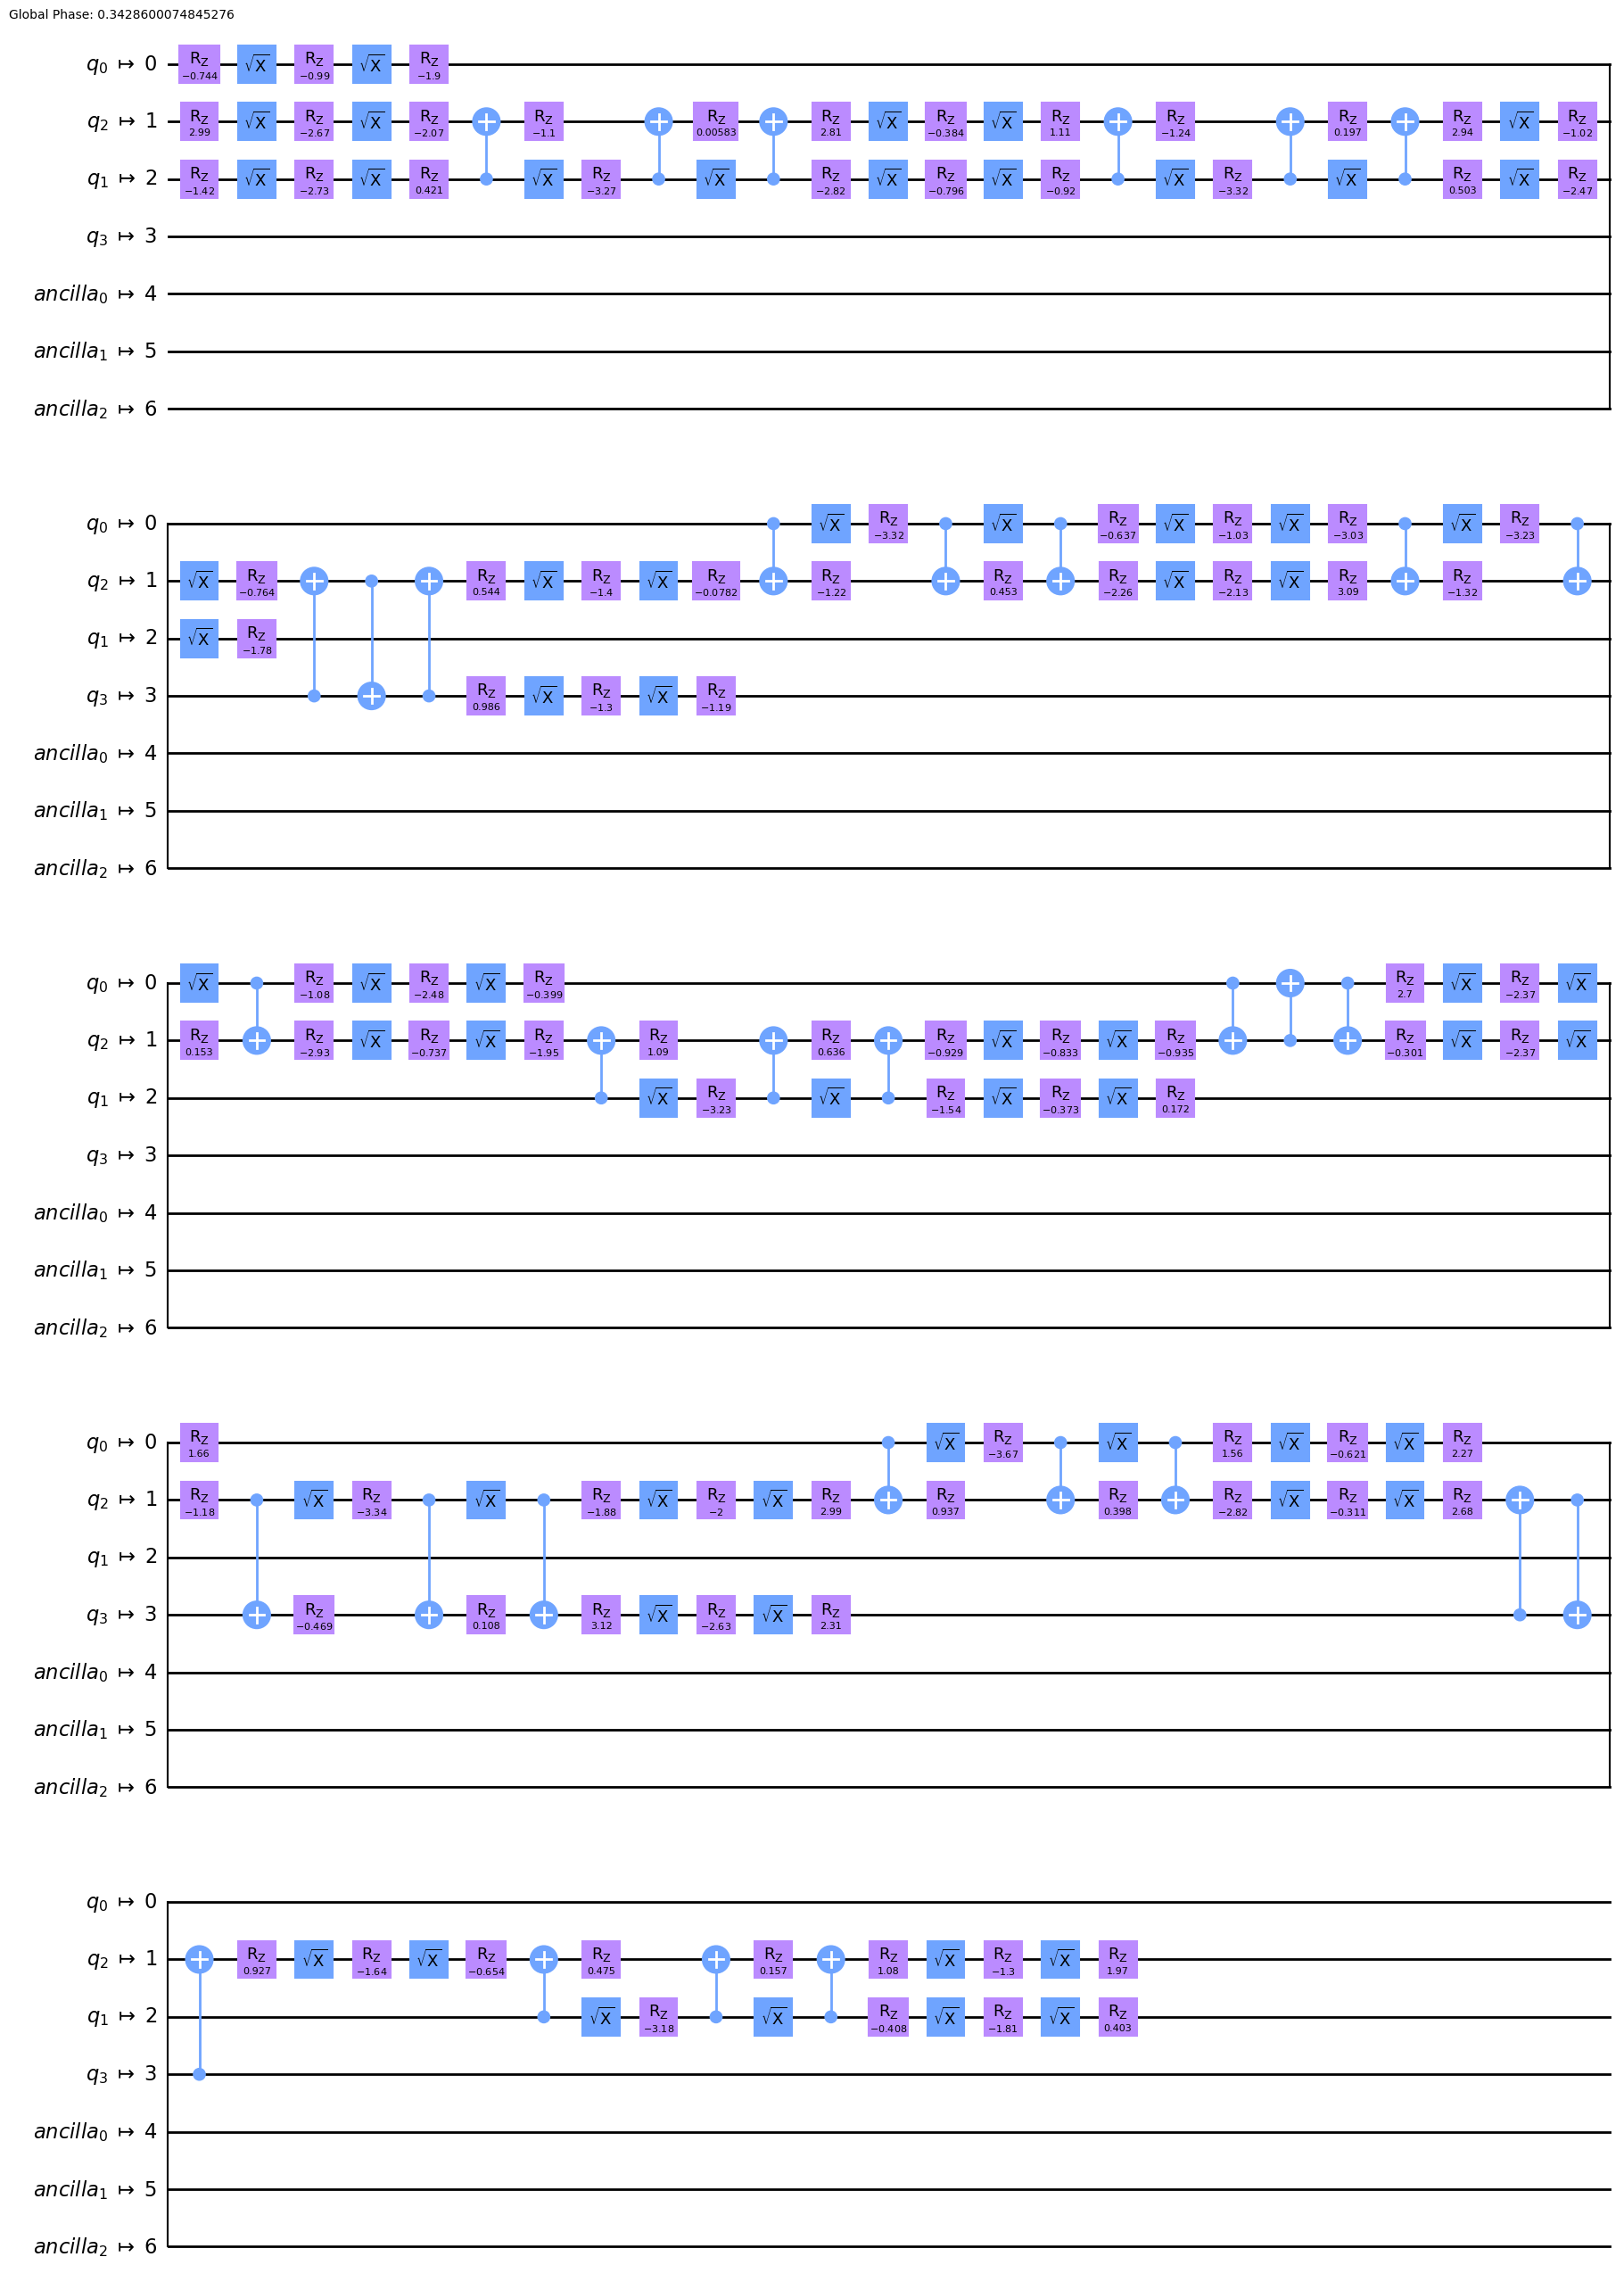

In [161]:
initial_layout=[0,2,1,3]
random.seed(100)
transpiled_circ_init=transpile(quantum_volume, jakarta, initial_layout=initial_layout)
transpiled_circ_init.draw("mpl")

We can see a total of 3 SWAP operations performed but it mostly between connected qubits (0 and 1 and 1 and 3 and again 1 and 3). Qubit 0 has the highest CNOT error and over the threshold of 3.09% ReadOut Error, at approximately 4%. Qubits 1, 2 and 3, on the other hand, have very low readout errors and low to very low CNOT error. Qubit 1 is connected to all other 3 qubits.  *Qubits 2, 3 and 0* can `use qubit 1 as a SWAP` if a two qubit gate needs to be performed between them, neither one of these, `apart from qubit 0 with highest CNOT error`, have high CNOT errors.

We can actually see this in the transpiled circuit that SWAP (3 alternating CNOTs) is conducted betweeen qubits 0 and 1 bringing 0 next to 2. 1 and 3 bringing 3 next to 0 and 2 etc.

Qubits 5, 4 and 6 aren't used as Ancilla Qubits. Especially that qubit 5, with highest readout error, isn't used in the circuit.

In [162]:
print(f"the depth of the circuit for {initial_layout} is: {transpiled_circ_init.depth()}")

the depth of the circuit for [0, 2, 1, 3] is: 117


This increase the depth of the circuit but again it has no bearing on the outcome and it may be due to compiler optimization and we can actually see that there are quite a number of unitary operation conducted in this circuit.

Furthermore, what's interesting is that no ancilla qubits are actually used and swap operations are between adjacent qubits. This also passes quantum volume test for 4 qubits. If we try this with a different optimization level such as optimization level 3. This will take more time but may yield a more optimized circuit. This will perform two types of optimization analysis:

1. Computational analysis on gates to see if it can collapse some gates
2. Peep Hole analysis. It combines a chain of gates on the same qubits and then it attempts to unify them again hoping to create a more optimized version.

The complier currently uses optimization_level=1 by default and does some light optimization.

It is worth mentioning that in `get_real_counts_initial_layout`function we have set the optimization_level to 3 already. So, it is already factored in when calculating a quantum volume and `ISHEAVY` test.


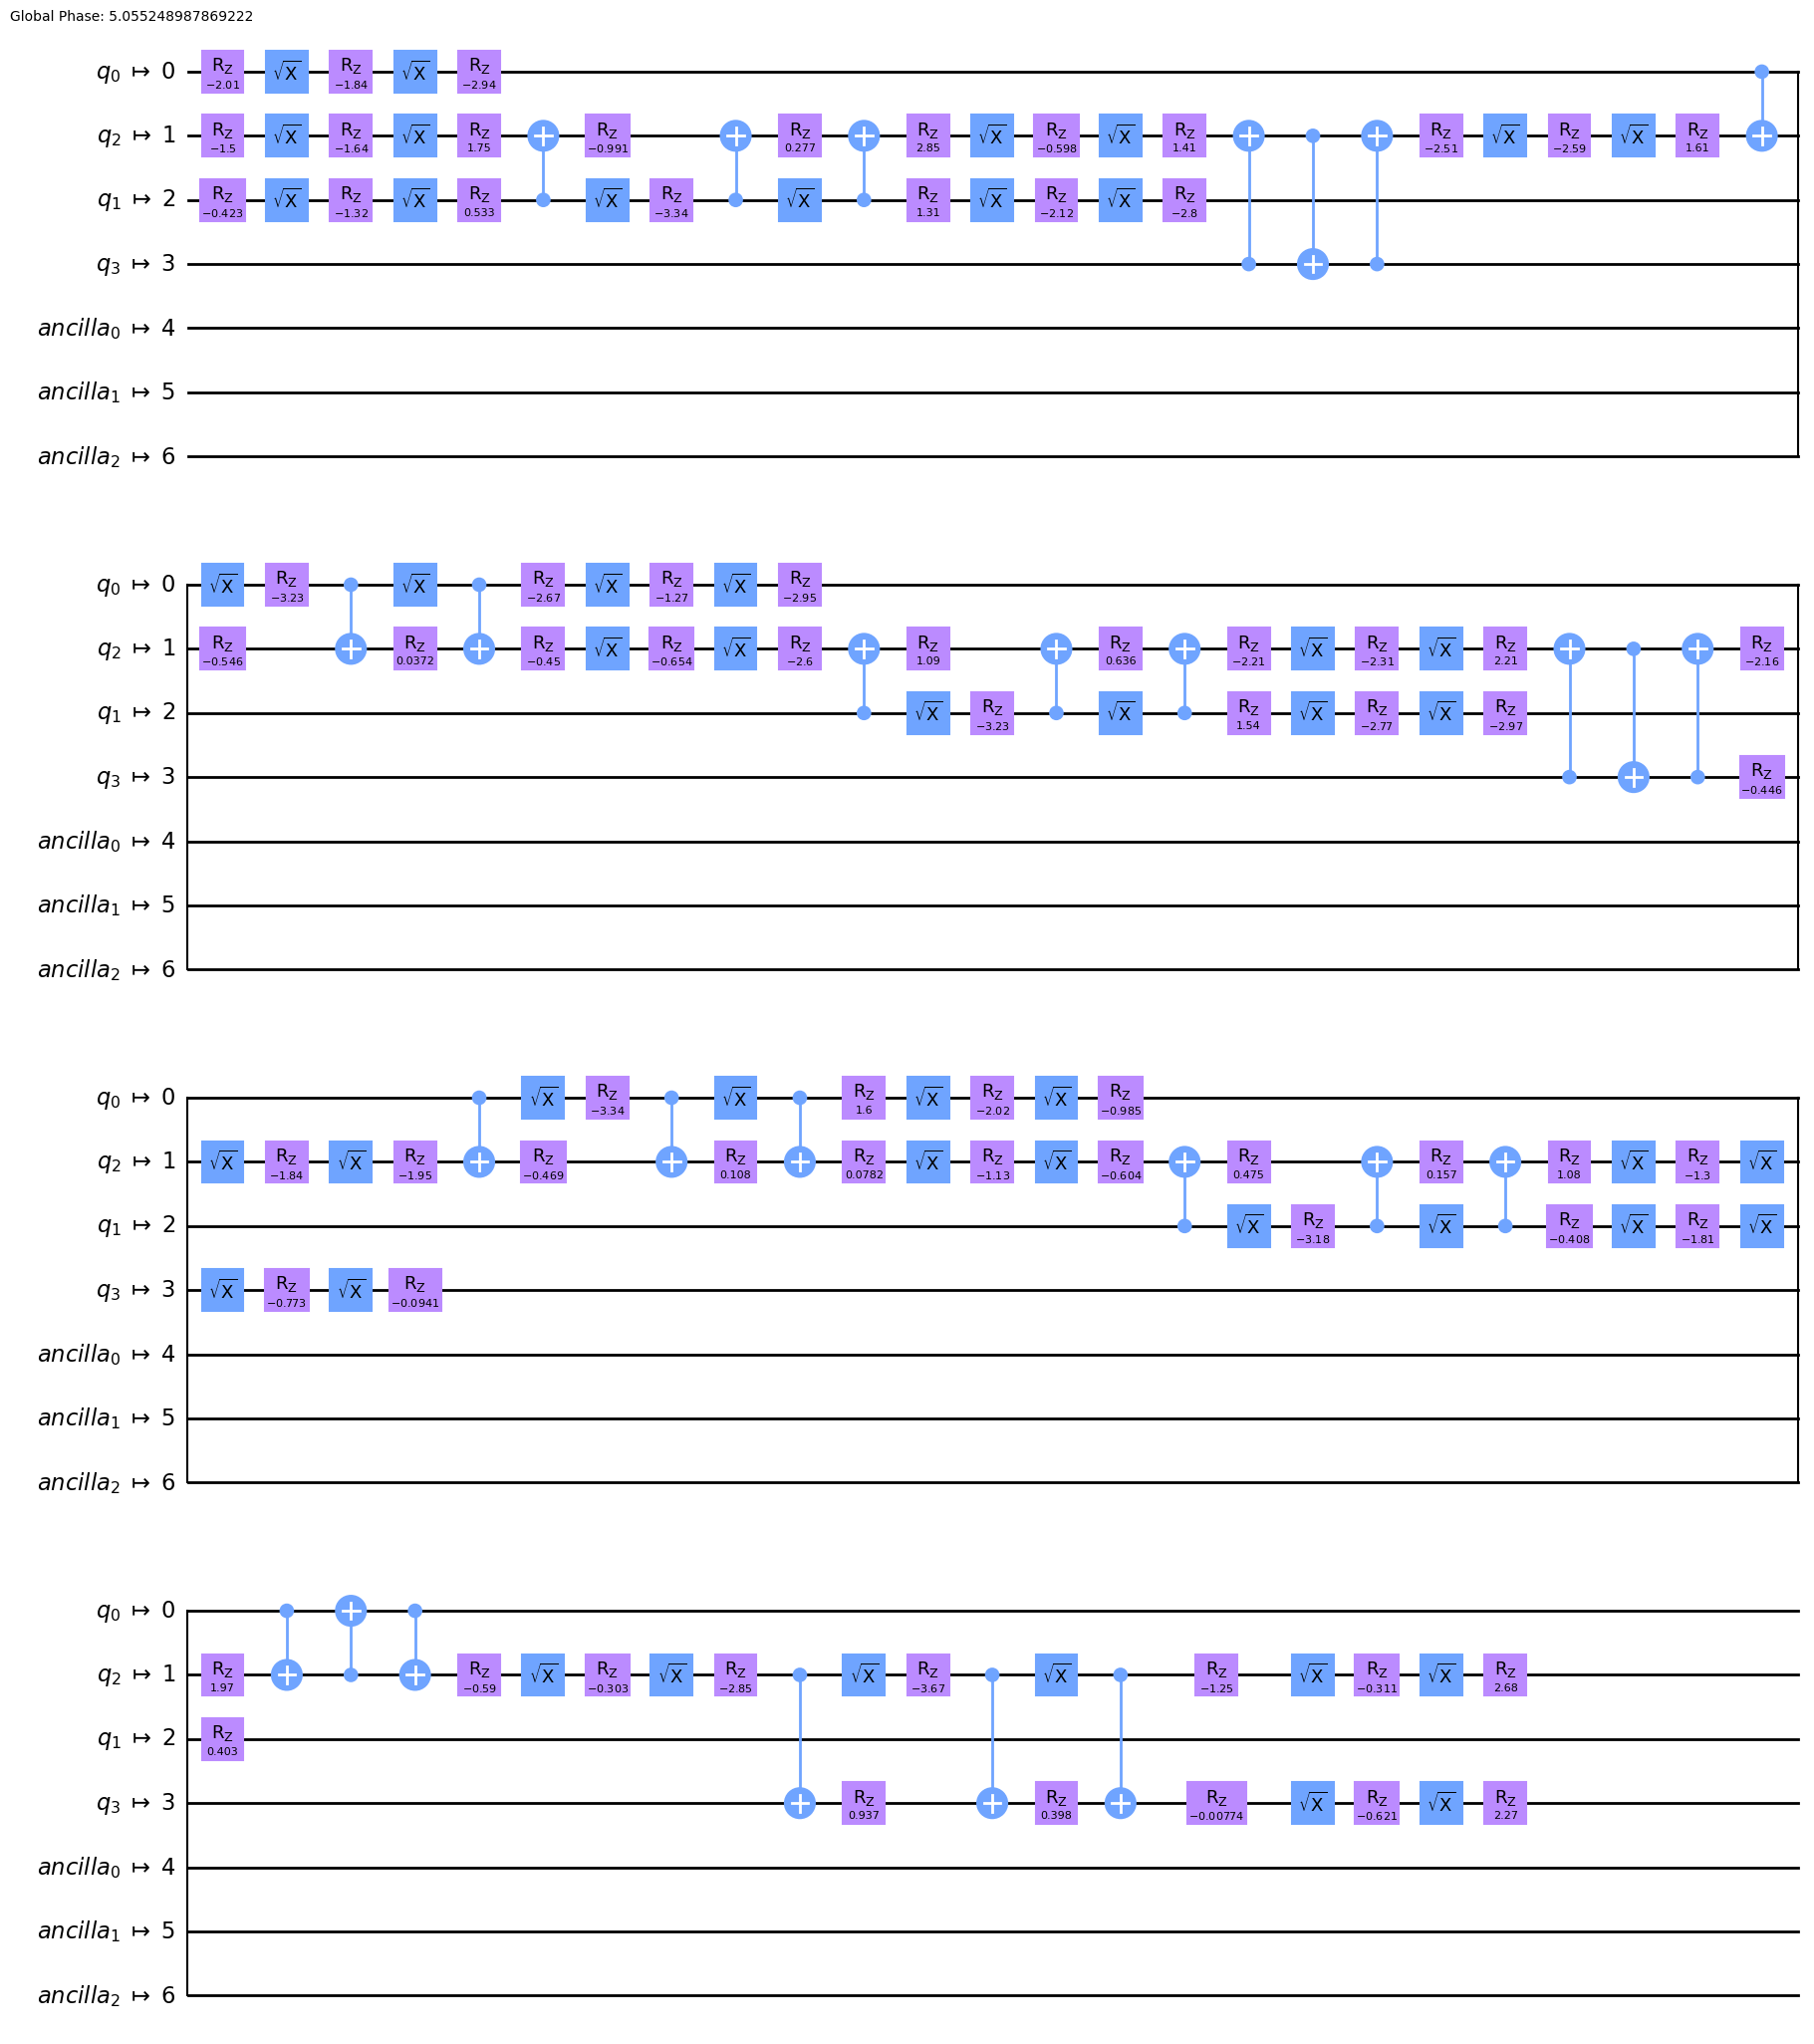

In [163]:
initial_layout=[0,2,1,3]
random.seed(100)
transpiled_circ_init=transpile(quantum_volume, jakarta, initial_layout=initial_layout, optimization_level=3)
transpiled_circ_init.draw("mpl")

**Concluding Observations:**




In a nutshell, having an idea of the error map and the coupling map of the hardware can help us make a more informed decision on having a more optimized circuit. Using connected qubits will help decrease SWAP operations, leading to less noise. Using qubits with low readout and low CNOT errors can lead to less noise creeping in, which helps in having heavier outputs, thereby higher likelihood of passing quantum volume test.   

In these experiments above, I avoided using more that 4 qubits since the reported IBM volume for Jakarta Machine is 16. 

## Part 4 Using Noise Model

The following functions create `topology`, create a `noise model` and add the noise model coupled with a topology of our choice to an `AerSimulator`. **`create_noise_model`** add both depolarizing and measurement error. However, the measurement error is controlled by a flag that is originally set to **False**  but it is later on toggled to **True** to also add measurement error to the machine. 

In [ ]:

def create_all_to_all_topology(num_qubits: int)->list[list]:
    '''create a fully connected topology'''
    fully_connected_edges=CouplingMap.from_full(num_qubits, bidirectional=False)

def create_square_topology(num_qubits: int)->list[list]:
    '''create a square topology'''
    allowed_qubits=[4,6,8,10,12]
    assert num_qubits in allowed_qubits
    rows=np.power(num_qubits,0.5).astype(int)
    square_map=CouplingMap.from_grid(rows, 
                                     np.floor(num_qubits/rows).astype(int), 
                                     bidirectional=False)
    return square_map

def create_loop_topology(num_qubits: int)->list[list]:
    '''create a loop topology'''
    edges=[]
    for i in range(num_qubits):
        edges.append([i,(i+1)%num_qubits])
    return edges


def create_quantum_machine(topology: list[list],
                           noise: NoiseModel)->AerSimulator:
    '''create a noisy machine for a given topology'''
    return AerSimulator(noise_model=noise, coupling_map=topology)


def create_noise_model(single_qubit_noise_proability: float,
                       double_qubit_noise_probability: float,
                       measurement_noise_probability: float,
                       measurement_error: bool=False)->NoiseModel:
    '''create a noise model using both depolarizing error 
       and measurement error (which is controlled by a bool flag)
       measurement bool is set to True in Question 5 to 
       add measurement error. 
    '''
    noise_model=NoiseModel()
    dephasing_error_one_qubit=depolarizing_error(single_qubit_noise_proability, 1)
    dephasing_error_two_qubits=depolarizing_error(double_qubit_noise_probability, 2)
    noise_model.add_all_qubit_quantum_error(dephasing_error_one_qubit, ['rz', 'sx', 'x', 'u3']) #single qubit noise
    noise_model.add_all_qubit_quantum_error(dephasing_error_two_qubits, ['cx']) #two qubit noise

    if measurement_error:
        #SOURCE: https://qiskit.org/ecosystem/aer/tutorials/3_building_noise_models.html
        meas_error=ReadoutError([[1 - measurement_noise_probability, measurement_noise_probability], 
                                    [measurement_noise_probability/2., 1 - measurement_noise_probability/2.]])
        noise_model.add_all_qubit_readout_error(meas_error)
    return noise_model


def set_seeds(seed=100)->None:
    random.seed(seed)
    np.random.seed(seed)


The function below `ISHEAVY_noisy` calls a number of other functions defined both for this particular question and the global functions defined at the beginning of this paper such as  `get_ideal_counts`, `get_heavy_outputs`. It also calls some methods of qiskit in order to perform heavy output test for one of the topologies, from the paper [Validating quantum computers using randomized model circuits](https://arxiv.org/abs/1811.12926). It also adds basis_gates and initial layout to circuits during the transpilation process. 

In [180]:
#calculate quantum volume for a noisy machine with depolarizing error channel
#for 4-6-8-12 qubits for 3 different topologies (loop, square and fully connected)
def ISHEAVY_noisy(num_circuits: int,
                  min_qubits: int,
                  max_qubits: int,
                  num_shots: int,
                  topology: str,
                  errors: list,
                  volume: str,
                  ideal_device,
                  measurement_err_bool: bool=False
                  ) -> dict:
    allowed_qubits = [4, 6, 8, 12]
    assert volume in ["qiskit", "haar", "random"]
    experiment_dict={}
    results_dict={}
    #error is double qubit error 
    #single qubit error is 1/10 error
    for error in errors:
        for nqubits in range(min_qubits, max_qubits + 1):
            if nqubits not in allowed_qubits: #the accepted number of qubits in the paper is 4,6,10,12
                continue
            
            noise_model=create_noise_model(single_qubit_noise_proability=error*0.1, #one qubit error is 0.1*two qubit error
                                            double_qubit_noise_probability=error, #two qubit error
                                            measurement_noise_probability=0.0, #set to zero here since we aren't adding any
                                            measurement_error=measurement_err_bool)
            noisy_device = create_quantum_machine(topology, noise_model)
            #this uses the qiskit's quantumvolume method
            if volume=="qiskit":
                qv_circuits = [QuantumVolumeCircuit(nqubits, classical_permutation=False) for _ in range(num_circuits)]
            #this calls the random circuit generator from question 2 using 7 one qubit unitaries 
            #and 3 alternating CNOTS. 
            if volume=="random":
                random_obj=RandomCircGenerator(device=noisy_device, 
                                               ideal_backend=ideal_device, 
                                               num_qubits=nqubits, 
                                               num_circuits=num_circuits, 
                                               division_const=2, 
                                               shots=num_shots)
                qv_circuits=[random_obj.generate_random_circuits(measure=False)]
            #this utilize's qiskit's random_unitary method to create quantum volume. 
            if volume=="haar":
                qv_circuits=[generate_random_circuits_unitary_qiskit(nqubits, 2, False)]
          
            num_heavies = 0

            for circuit in qv_circuits:
                circuit.measure_all()
                # print(circuit)
                ideal_counts = get_ideal_counts(circuit, ideal_device, shots=num_shots)
                ideal_heavy_outputs = get_heavy_outputs(ideal_counts)
          
                #transpiles circuit using custom basis gates and optim level 3 
                transpiled_circuit = transpile(
                    circuit,
                    noisy_device,
                    coupling_map=noisy_device.configuration().coupling_map,
                    basis_gates=['rz', 'sx', 'x', 'cx'],
                    initial_layout=list(range(nqubits)),
                    optimization_level=3
                )

                #executes the transpiled circuits
                real_counts = execute(transpiled_circuit, noisy_device, shots=num_shots).result().get_counts()
     
                # probability_dict = {key: value/sum(real_counts.values()) for key, value in real_counts.items()}
          
                for bitstr, val in real_counts.items():
                    if bitstr in ideal_heavy_outputs:
                        num_heavies += val
            result = heavy_output_test(num_heavies, num_circuits, num_shots)
            results_dict[(nqubits, error)]=result
            print(f"result is {result} for number of qubits {nqubits} and for two qubit error of {error}")
            if result>2/3: 
                experiment_dict[nqubits]=error
                print(f"passed heavy output test. Result is {result} for two qubit error of {error} and number of qubits {nqubits}")
    return results_dict, experiment_dict

In [182]:
set_seeds()

Running these experiments for 3 different topologies and for qiskit's quantim volume first. I have picked the errors that we found to pass quantum volume test for a given topology from the paper. Running this task is computationally very expensive. Due to the large number of circuits we need to iterate through for each one of these two qubit errors and for the qubits within allowed qubit ranges specified in the code, I have taken the liberty of running the Heavy Tests for 200 circuits and 200 shots, instead of 1000 circuits as suggested in the paper. I have then, judging based on the heavy output printouts, approximated the error needed to pass heavy output test for a given topology. However, this approximation is a heuristic and subjective only and doesn't yield the expected results as shown below. 

In [106]:
num_circuits=200 ##The paper runs 1,000 circuits. I have decided to run 200 circuits. 
min_qubits=2
max_qubits=12
num_shots=200 
topology=create_loop_topology(max_qubits)
errors=[0.0014, 0.011, 0.028] #two qubit errors taken from paper for loop
volume="qiskit"

loop_results_qiskit, loop_experiment_qiskit=ISHEAVY_noisy(num_circuits=num_circuits,
                  min_qubits=min_qubits,
                  max_qubits=max_qubits,
                  num_shots=num_shots,
                  topology=topology,
                  errors=errors,
                  volume=volume,
                  ideal_device=AerSimulator(),
                  measurement_err_bool=False
                  )

result is 0.7625049859111416 for number of qubits 4 and for two qubit error of 0.0014
passed heavy output test. Result is 0.7625049859111416 for two qubit error of 0.0014 and number of qubits 4
result is 0.6653727977186098 for number of qubits 6 and for two qubit error of 0.0014
result is 0.4381146807550156 for number of qubits 8 and for two qubit error of 0.0014
result is 0.04881568295831216 for number of qubits 12 and for two qubit error of 0.0014
result is 0.6537465565520437 for number of qubits 4 and for two qubit error of 0.011
result is 0.46841368201758043 for number of qubits 6 and for two qubit error of 0.011
result is 0.2721513338803503 for number of qubits 8 and for two qubit error of 0.011
result is 0.03603113723504092 for number of qubits 12 and for two qubit error of 0.011
result is 0.5496755826265307 for number of qubits 4 and for two qubit error of 0.028
result is 0.4027025693074591 for number of qubits 6 and for two qubit error of 0.028
result is 0.2608046835757278 for 

The following dictionary stores the approximate results, based on the printouts. If I had ran more circuits and for more shots, I would probably gotten more accurate results. This approximation helps me do some drawing. The same approximation is used to store results of experiments on other topologies

In [218]:
loop_results={
    4: 0.020,
    6: 0.011,
    8: 0.0014,
    12: 0.0001 
}

In [111]:
num_circuits=200 #The paper runs 1,000 circuits. I have decided to run 200 circuits.
min_qubits=2
max_qubits=12
num_shots=200 
topology=create_square_topology(max_qubits)
errors=[0.0014, 0.011, 0.028] #two qubit errors taken from paper for square
volume="qiskit"

square_results_qiskit, experiment_square_qiskit=ISHEAVY_noisy(num_circuits=num_circuits,
                  min_qubits=min_qubits,
                  max_qubits=max_qubits,
                  num_shots=num_shots,
                  topology=topology,
                  errors=errors,
                  volume=volume,
                  ideal_device=AerSimulator(),
                  measurement_err_bool=False
                  )

result is 0.7501611207972475 for number of qubits 4 and for two qubit error of 0.0014
passed heavy output test. Result is 0.7501611207972475 for two qubit error of 0.0014 and number of qubits 4
result is 0.6434852800674682 for number of qubits 6 and for two qubit error of 0.0014
result is 0.5152417531791178 for number of qubits 8 and for two qubit error of 0.0014
result is 0.027951197640063617 for number of qubits 12 and for two qubit error of 0.0014
result is 0.6440176369444931 for number of qubits 4 and for two qubit error of 0.011
result is 0.4683025447267775 for number of qubits 6 and for two qubit error of 0.011
result is 0.3605737706284281 for number of qubits 8 and for two qubit error of 0.011
result is 0.017174384076386353 for number of qubits 12 and for two qubit error of 0.011
result is 0.536149436801571 for number of qubits 4 and for two qubit error of 0.028
result is 0.3719142003676188 for number of qubits 6 and for two qubit error of 0.028
result is 0.34529419211504503 for

In [219]:
square_results={
    4: 0.020,
    6: 0.017,
    8: 0.002,
    12: 0.0001
}

In [114]:
num_circuits=200 #The paper runs 1,000 circuits. I have decided to run 200 circuits.
min_qubits=2
max_qubits=12
num_shots=200 
topology=create_all_to_all_topology(max_qubits)
errors=[0.0014, 0.011, 0.028] #two qubit errors taken from paper for fully connected
volume="qiskit"

full_results_qiskit, experiment_full_qiskit=ISHEAVY_noisy(num_circuits=num_circuits,
                  min_qubits=min_qubits,
                  max_qubits=max_qubits,
                  num_shots=num_shots,
                  topology=topology,
                  errors=errors,
                  volume=volume,
                  ideal_device=AerSimulator(),
                  measurement_err_bool=False
                  )

result is 0.7491905436555576 for number of qubits 4 and for two qubit error of 0.0014
passed heavy output test. Result is 0.7491905436555576 for two qubit error of 0.0014 and number of qubits 4
result is 0.652468157328017 for number of qubits 6 and for two qubit error of 0.0014
result is 0.5482524909542171 for number of qubits 8 and for two qubit error of 0.0014
result is 0.03460311583620434 for number of qubits 12 and for two qubit error of 0.0014
result is 0.6640502702386748 for number of qubits 4 and for two qubit error of 0.011
result is 0.4852770752707702 for number of qubits 6 and for two qubit error of 0.011
result is 0.37979163482570105 for number of qubits 8 and for two qubit error of 0.011
result is 0.017926699923923126 for number of qubits 12 and for two qubit error of 0.011
result is 0.5642134558728777 for number of qubits 4 and for two qubit error of 0.028
result is 0.4008794867750082 for number of qubits 6 and for two qubit error of 0.028
result is 0.35425768604488755 for

In [220]:
full_results={
    4: 0.020,
    6: 0.017,
    8: 0.004,
    12: 0.0001
}

In [221]:
def plot_graph(res_loop: dict,
               res_square: dict,
               res_full: dict,
               x_label: str,
               y_label: str,
               )->None:
    '''plots a graph for 1/ε and log2QV where ε is two qubit error'''
    plt.plot([1/val for val in list(res_loop.values())], 
             list(res_loop.keys()),'^', color="orange",label="loop Eq.8")
    plt.plot([1/val for val in list(res_square.values())], 
             list(res_square.keys()), 'bo', label="Square Eq.8")
    plt.plot([1/val for val in list(res_full.values())], 
             list(res_full.keys()),'rs', label="Full Eq.8")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc="upper left", frameon=False)
    plt.show()

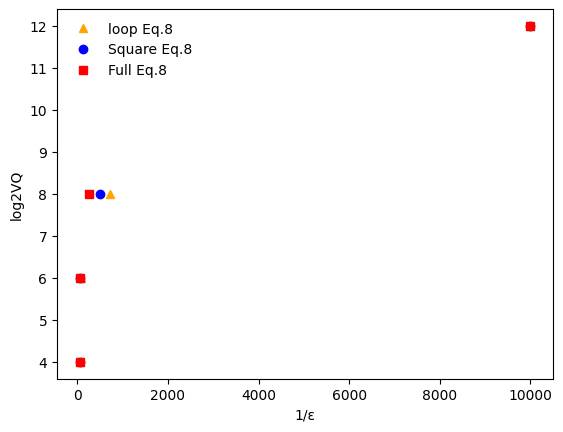

In [222]:
plot_graph(loop_results, square_results, full_results, "1/ε", "log2VQ")

This function doesn't really show the differences between these three. So, I have modified it a bit to draw lines. It shows that fully connected topology performs better than other topologies. This makes sense given that the qubits are all connected in a full topology, they don't need SWAP operations. SWAP operations are error prone and can affect heavy output.

In [227]:
def plot_graph_line(res_loop: dict,
               res_square: dict,
               res_full: dict,
               x_label: str,
               y_label: str,
               )->None:
    '''plots a graph for 1/ε and log2QV where ε is two qubit error'''
    plt.plot([1/val for val in list(res_loop.values())], 
             list(res_loop.keys()),'-', color="orange",label="loop Eq.8")
    plt.plot([1/val for val in list(res_square.values())], 
             list(res_square.keys()), 'b--', label="Square Eq.8")
    plt.plot([1/val for val in list(res_full.values())], 
             list(res_full.keys()),'r--', label="Full Eq.8")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc="upper left", frameon=False)
    plt.show()

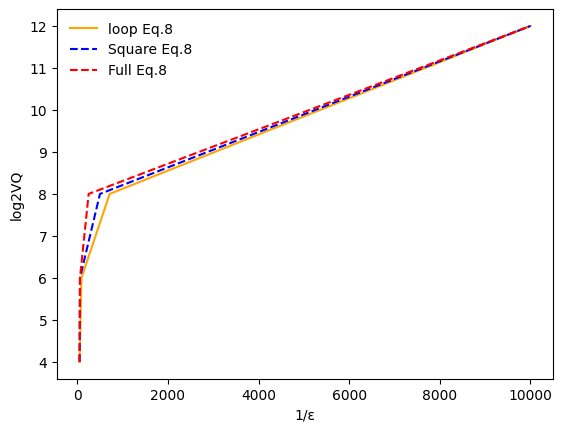

In [228]:
plot_graph_line(loop_results, square_results, full_results, "1/ε", "log2VQ")

In [229]:
from IPython.display import display

import pandas as pd
def generate_table(loop: dict,
                   square: dict,
                   full: dict)->pd.DataFrame:
    topologies = {
    'Log2 VQ': loop.keys(), 
    "All-to-All": full.values(),
    "Square Grid": square.values(),
    "Loop": loop.values(),
    }
    df = pd.DataFrame.from_dict(topologies, orient='index').transpose()
    return df

In [230]:
df=generate_table(loop_results, square_results, full_results)
display(df)

,Log2 VQ,All-to-All,Square Grid,Loop
0,4.0,0.0200,0.0200,0.0200
1,6.0,0.0170,0.0170,0.0110
2,8.0,0.0040,0.0020,0.0014
3,12.0,0.0001,0.0001,0.0001


As we can see the results aren't 100% the same as shown in the paper but judging based on the printouts and the approximated data I have come up with based on the printout, the all-in-all topology shows better results. **However, a more granular experiment with more errors to test as well as 1000 circuits with more than 1000 shots to test the errors on would be needed to produce more accurate results**. 

## Using Measurement Error

In this part, we will improve on the noise model by also introducing measurement error. I have set the Boolean flag to True in the function `ISHEAVY_noisy_meas` which then introduces measurement error to the noise model. The experiment is run for Square Topology only as indicated in the paper. It is run for 200 circuits and two qubit depolarizing error of **[0.02, 0.0021, 0.00021]**. 

In [190]:
def ISHEAVY_noisy_meas(num_circuits: int,
                  min_qubits: int,
                  max_qubits: int,
                  num_shots: int,
                  topology: str,
                  errors: list,
                  volume: str,
                  measurement_errors: list,
                  ideal_device,
                  measurement_err_bool: bool=True
                  ) -> list:
    '''calculates quantum volume for a square topology 
       for 4, 6, 8, 12 qubits of a noisy machine with both measurement
       and depolarizing errors.
    '''
    allowed_qubits = [4, 6, 8, 12] #list of allowed qubits according to paper topology
   
    results = []
    measurement_dict={}
    dephasing_dict={}
    for meas_error in measurement_errors:
        for error in errors:
            two_qubits_error = error
            one_qubit_error = error*0.1
            
            for nqubits in range(min_qubits, max_qubits + 1):
                if nqubits not in allowed_qubits:
                    continue
      
                noise_model=create_noise_model(single_qubit_noise_proability=one_qubit_error,
                                               double_qubit_noise_probability=two_qubits_error,
                                               measurement_noise_probability=meas_error,
                                               measurement_error=measurement_err_bool)
        
                noisy_device = create_quantum_machine(topology, noise_model)

                qv_circuits = [QuantumVolumeCircuit(nqubits, classical_permutation=False) for _ in range(num_circuits)]

                num_heavies = 0
                for circuit in qv_circuits:
                    circuit.measure_all()
                    ideal_counts = get_ideal_counts(circuit, ideal_device, shots=num_shots)
                    ideal_heavy_outputs = get_heavy_outputs(ideal_counts)

                    transpiled_circuit = transpile(
                        circuit,
                        noisy_device,
                        coupling_map=noisy_device.configuration().coupling_map,
                        basis_gates=['rz', 'sx', 'x', 'cx'],
                        initial_layout=list(range(nqubits)),
                        optimization_level=3
                    )

                    real_counts = execute(transpiled_circuit, noisy_device, shots=num_shots).result().get_counts()
                    # probability_dict = {key: value/sum(real_counts.values()) for key, value in real_counts.items()}
          
                    for bitstr, val in real_counts.items():
                        if bitstr in ideal_heavy_outputs:
                            num_heavies += val
                result = heavy_output_test(num_heavies, num_circuits, num_shots)
                print(f"the result is {result} for {nqubits} number of qubits and measurement error of {meas_error}" 
                      f" and two qubit error of {error}")
                if result>2/3:
                    dephasing_dict[nqubits]=two_qubits_error
                    results.append(dephasing_dict)
                    measurement_dict[nqubits]=meas_error
                    results.append(measurement_dict)
                    results.append("====================================")
    return results

In [141]:
num_circuits=200
min_qubits=2
max_qubits=12
num_shots=200
topology=create_square_topology(max_qubits)
errors=[0.02, 0.0021, 0.00021]
measurement_errors=[0.0, 0.01, 0.05]



In [142]:
res=ISHEAVY_noisy_meas(num_circuits=num_circuits,
                  min_qubits=min_qubits,
                  max_qubits=max_qubits,
                  num_shots=num_shots,
                  topology=topology,
                  errors=errors,
                  volume="qiskit",
                  measurement_errors=measurement_errors,
                  ideal_device=AerSimulator(),
                  measurement_err_bool=True
                  )

the result is 0.5681113084340975 for 4 number of qubits and measurement error of 0.0 and two qubit error of 0.02
the result is 0.4009786800711255 for 6 number of qubits and measurement error of 0.0 and two qubit error of 0.02
the result is 0.34812466173917145 for 8 number of qubits and measurement error of 0.0 and two qubit error of 0.02
the result is 0.016756343796036043 for 12 number of qubits and measurement error of 0.0 and two qubit error of 0.02
the result is 0.731214975849078 for 4 number of qubits and measurement error of 0.0 and two qubit error of 0.0021
the result is 0.6218437279888491 for 6 number of qubits and measurement error of 0.0 and two qubit error of 0.0021
the result is 0.50049575012901 for 8 number of qubits and measurement error of 0.0 and two qubit error of 0.0021
the result is 0.022776821950689988 for 12 number of qubits and measurement error of 0.0 and two qubit error of 0.0021
the result is 0.7684921166094202 for 4 number of qubits and measurement error of 0.0

Now we can use the function below to attempt to recreate Table IV of the paper

In [165]:
def generate_table_meas(measurement: dict) -> pd.DataFrame:
    '''create a table and attempts to recreate TABLE IV of the Paper'''
    df = pd.DataFrame(measurement).transpose()
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Log2 VQ'}, 
              inplace=True)
    df.rename(columns={0: '0% meas.error', 
                       1: '1% meas.error', 
                       2: '5% meas.error'}, 
              inplace=True)
    return df

In [163]:
measurement_results={
    
    4: [0.022, 0.021, 0.02],
    6: [0.002, 0.0018, 0.0016],
    8: [0.0016, 0.0012, 0.0011],
    12: ["NA", "NA", "NA"]
}

In [164]:
df=generate_table_meas(measurement_results)
display(df)

,Log2 VQ,0% meas.error,1% meas.error,5% meas.error
0,4,0.022,0.021,0.02
1,6,0.002,0.0018,0.0016
2,8,0.0016,0.0012,0.0011
3,12,NA,NA,NA


As we can see the results are not the same as those reported by the paper. I approximated the results and stored them in `measurement_results` dictionary based on the print outs from `printf`. I have only tested three depolarizing errors and looked for approximations due to the computational costs of running 200 circuits for each measurement error and each depolarizing error. A more granular testing could have produced a more accurate results. The heavy output results for a 12 qubit square topology stay below 10% all all times so I have simply decided to choose `NA` as I was not able to approximate this to anything meaningful. However, the findings collaborate the fact that the increase in error (measurement or depolarizing error) could adversely impact quantum volume. 

## Concluding Remarks:

Replicating the research findings in regarding impacting noise on Quantum Volume with my computational resources was very challenging. Therefore, I needed to recourse to approximation by looking at the printouts. 


## Appendix and References

The following resources have been consulted throughout this short paper.

1. [Qiskit Textbook](https://qiskit.org/learn)

2. [Qiskit Quantum Volume from Qiskit Textbook](https://learn.qiskit.org/course/quantum-hardware/measuring-quantum-volume)

3. [Quantum Volume Qiskit](https://qiskit.org/documentation/_modules/qiskit/circuit/library/quantum_volume.html)

4. **Dr. Stefano Gogioso**. `Quantum Computing Course`. **University of Oxford**

5. [Qiskit Noise Model](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.noise.NoiseModel.html)

6. [Qiskit Documentations](https://qiskit.org/documentation/)

7. [PennyLane Quantum Volume](https://pennylane.ai/qml/demos/quantum_volume#the-measures-of-success)